# DQN

## 4つの工夫
1. Experience Replay  
メモリに各ステップの内容を保存しておいて、後からランダムに取り出して(replay)、ニューラルネットワークに学習させる方法。ここでの、1ステップの内容を **transition**とも呼ぶ。  
殊、ゲームの学習では時間的な相関がとても高い。すなわち、隣接する時刻での学習内容が非常に似ているため、結合パラメータの学習が安定しづらいという問題がある。Experience Replayではこの問題が解消され、さらに、ミニバッチで学習させることもできる。

2. Fixed Target Q-Network  
行動を決定する**main network**と誤差関数の計算時に行動価値を求める**target network**の2種類のニューラルネットで構成される。
Q学習では$Q(s_t, a)$と$\max_a Q(s_{t+1}, a)$を求める必要があるが、両方を同じQ関数にすると更新が不安定になるらしい。そこで、後者については少し前の時間のQ関数(Fixed Target Q-network)を使って計算する。

    少し前の時間のQ関数は結合パラメータが少し前ものであるという意味で、target networkは定期的にmain networkで上書きされる。
3. 報酬のクリッピング  
報酬の集合を制限する。
例えば$\{-1, 0 , 1\}$
4. Huber関数で誤差を計算
$$
    H(x, y) = \begin{cases}
        (x - y)^2 & |x - y| < 1 \\
        |x - y|   & \mathrm{otherwise} 
    \end{cases}
$$

## PytorchでDQNを実装するときの注意点
1. Experience Replay, (疑似的な)Fixed Target Q-Learningでミニバッチ学習を実行する点  
棒が倒れたり、200ステップまで行ったら次状態$s_{t+1}$が存在しない。存在するか否かで、場合分けが必要

2. Pytorchでのミニバッチの扱い方  
ミニバッチの実装には慣れが必要

3. データの型  
CartPoleではNumpy型で扱うが、PyTorchではTorch.Tensorのテンソル型で扱う

4. Torch.Tensorのサイズ  
size 1のとsize 1×1のがあるから注意

5. namedtupleの使用  
python3.7だしdataclassでもええやろ  
google colaboratoryの環境が3.6.6だったので、やめておく

## google colaboratory用のセル
google colaboraryだと仮想環境に時間制限があるらしいので、毎回入れるように指定する

In [1]:
!pip3 install -q torch torchvision
!pip3 install -q gym
! pip3 install -q JSAnimation

!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so

!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip install -q pyglet
!pip install -q pyopengl
!pip install -q pyvirtualdisplay
!pip install -q gym[classic_control]

'pip3' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。
'pip3' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。
'pip3' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。
指定されたパスが見つかりません。
'ln' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。
指定されたパスが見つかりません。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

## 動画の保存部分

In [2]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
              dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis("off")
    
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    
    anim.save("movie_cartpole_DQN.mp4")
    display(display_animation(anim, default_mode="loop"))

## namedtupleの実装

In [3]:
from collections import namedtuple

Transition = namedtuple(
"Transition", ("state", "action", "next_state", "reward"))

## 定数宣言

In [4]:
ENV = "CartPole-v0"
GAMMA = 0.99 # discount rate
MAX_STEPS = 200 
NUM_EPISODES = 500 # 最大試行回数 

## 経験を保存するメモリクラス
元の実装とは違うがdequeのラッパとする

In [5]:
from collections import deque

class ReplayMemory:
    def __init__(self, capacity):
        self.__memory = deque(maxlen=capacity)
        
    @property
    def capacity(self): return self.__memory.maxlen
    
    @property
    def memory(self): return self.__memory
    
    def push(self, state, action, state_next, reward):
        self.memory.append(Transition(state, action, state_next, reward))
        
    def sample(self, batch_size):
        return random.sample(self.__memory, batch_size)
    
    def __len__(self) : return len(self.__memory)
    

## 行動決定器

In [6]:
import random
import torch
from torch import nn, optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000

class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions
        self.memory = ReplayMemory(CAPACITY)
        
        # NNの構築
        self.model =  nn.Sequential()
        add = self.model.add_module
        add("fc1", nn.Linear(num_states, 32))
        add("relu1", nn.ReLU())
        add("fc2", nn.Linear(32,32))
        add("relu2", nn.ReLU())
        add("fc3", nn.Linear(32, num_actions))
        
        print(self.model)
        
        # 最適化手法
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        
    def replay(self):
        '''Experience Replayで結合パラメータを学習'''
        
        # メモリサイズのチェック
        if len(self.memory) < BATCH_SIZE:
            return
        
        # ミニバッチの作成
        transitions = self.memory.sample(BATCH_SIZE)
        
        # (s,a,s,r) * BATCH_SIZE -> (s * BATCH_SIZE, a * BATCH_SIZE, s * BATCH_SIZE, r * BATCH_SIZE)に変形
        batch = Transition(*zip(*transitions))
        
        #---------------------------------------------
        # torch.cat(seq, dim=0, out=None) → Tensor
        # 
        #---------------------------------------------
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        # Q(s_t, a_t)を求める
        #　推論モードに切り替え
        self.model.eval()
        
        # torch.gather(input, dim, index, out=None) → Tensor
        # action_batchで行動を固定してQ(s)を取得する
        state_action_values = self.model(state_batch).gather(1, action_batch)
        
        # max_a Q(s_{t+1}, a)を求める
        
        non_final_mask = torch.ByteTensor(
            tuple(map(lambda s: s is not None, batch.next_state)))
        next_state_values = torch.zeros(BATCH_SIZE)
        
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()
        
        # 教師信号Q(s_t, a_t)
        expected_state_action_values = reward_batch + GAMMA * next_state_values
        
        #-------------------------------
        # 結合パラメータ更新フェーズ
        #-------------------------------
        self.model.train()
        
        # torch.unsqueeze(input, dim, out=None) → Tensor
        # 
        loss = F.smooth_l1_loss(state_action_values,
                               expected_state_action_values.unsqueeze(1))
        
        # 更新
        self.optimizer.zero_grad() # 勾配をリセット
        loss.backward()            # BPを計算
        self.optimizer.step()      # 結合パラメータの更新
        
    def decide_action(self, state, episode):
        """
        εーグリーディで行動選択
        return torch.LongTensor of size 1x1
        """
        eps = 0.5 * (1 / (episode  +1))
        
        if eps <= np.random.uniform(0,1):
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1,1)
        else:
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])
            
        return action

## CartPoleで動くエージェントのクラス

In [7]:
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
        
    def update_q_func(self):
        self.brain.replay()
        
    def get_action(self, state, episode):
        return self.brain.decide_action(state, episode)
    
    def memorize(self, state, action, state_next, reward):
        self.brain.memory.push(state, action, state_next, reward)
        

## 環境のクラス

In [8]:
class Environment:
    def __init__(self):
        self.env = gym.make(ENV)
        self.num_states = self.env.observation_space.shape[0]
        self.num_action = self.env.action_space.n
        
        self.agent : Agent = Agent(self.num_states, self.num_action)
        
    def run(self):
        episode_10_list = np.zeros(10)
        
        complete_episodes = 0
        episode_final = False
        frames = []
        
        for episode in range(NUM_EPISODES): # 試行のループ
            observation = self.env.reset() # 環境の初期化
            
            state = Environment.__numpy2tensor_state(observation)            
            for step in range(MAX_STEPS):
                if episode_final :
                    frames.append(self.env.render(mode="rgb_array"))
                
                action = self.agent.get_action(state, episode)
                
                # _ はそれぞれ、reward, info
                observation_next, _ , done, _ = self.env.step(action.item())
                
                if done: # 200step経過 or コケる
                    state_next = None
                    # numpy.hstack 水平方向に連接
                    episode_10_list = np.hstack((episode_10_list[1:], step+1))
                    
                    if step < 195: #コケて終了は-1
                        reward =torch.FloatTensor([-1.0])
                        complete_episodes=0
                    else:         # 生き残ったら+1
                        reward = torch.FloatTensor([1.0])
                        complete_episodes += 1
                else:
                    reward = torch.FloatTensor([0.0])
                    state_next = Environment.__numpy2tensor_state(observation_next)
                    
                self.agent.memorize(state, action, state_next, reward)
                self.agent.update_q_func()
                state = state_next
                    
                if done:
                    print(
                    "%3d Episode: finished after %3d steps: 10 avg. = %.2f" % (
                        episode, step + 1, episode_10_list.mean() ))
                    break
            if episode_final:
                display_frames_as_gif(frames)
                break
            
            if complete_episodes  >= 10:
                print("10回連続成功")
                episode_final = True
                
                
    @staticmethod
    def __numpy2tensor_state(state):
        # numpy -> torch.FloatTensor
        state = torch.from_numpy(state).type(torch.FloatTensor)

        # FloatTensor of size 4 -> FloatTensor of 1x4 
        return torch.unsqueeze(state ,0)

## google colaboratory で画面を表示する

In [9]:
from pyvirtualdisplay import Display
disp = Display(visible=0, size=(1024, 768))
disp.start()
import os
os.environ["DISPLAY"] = ":" + str(disp.display) + "." + str(disp.screen)

EasyProcessCheckInstalledError: cmd=['Xvfb', '-help']
OSError=[WinError 2] 指定されたファイルが見つかりません。
Program install error! 

## main

Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
  0 Episode: finished after  24 steps: 10 avg. = 2.40
  1 Episode: finished after  11 steps: 10 avg. = 3.50
  2 Episode: finished after  14 steps: 10 avg. = 4.90
  3 Episode: finished after   9 steps: 10 avg. = 5.80
  4 Episode: finished after  13 steps: 10 avg. = 7.10
  5 Episode: finished after  16 steps: 10 avg. = 8.70
  6 Episode: finished after  16 steps: 10 avg. = 10.30
  7 Episode: finished after  16 steps: 10 avg. = 11.90
  8 Episode: finished after  22 steps: 10 avg. = 14.10
  9 Episode: finished after  26 steps: 10 avg. = 16.70
 10 Episode: finished after  19 steps: 10 avg. = 16.20
 11 Episode: finished after  17 steps: 10 avg. = 16.80
 12 Episode: finished after  17 steps: 10 avg. = 17.10
 13 Episode: finished after  23 steps: 10 avg. = 18.50
 14 Epis


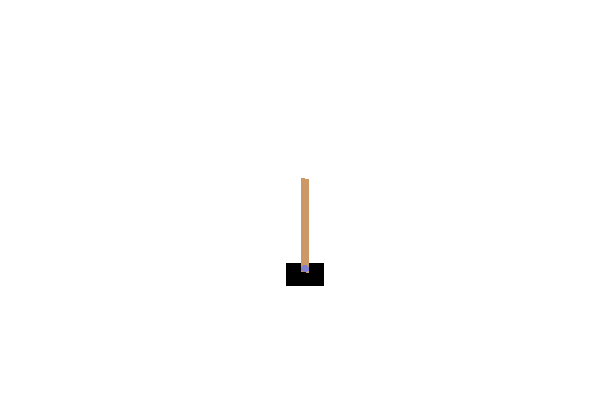
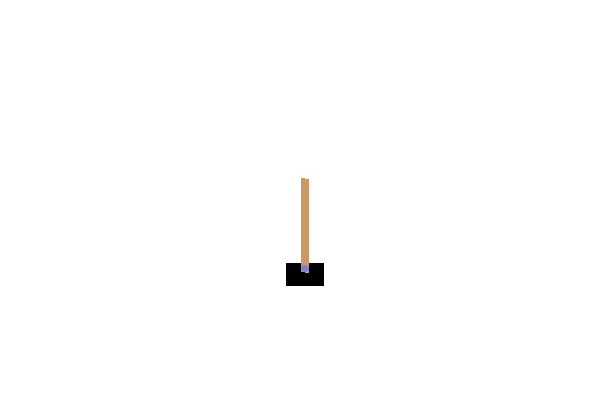
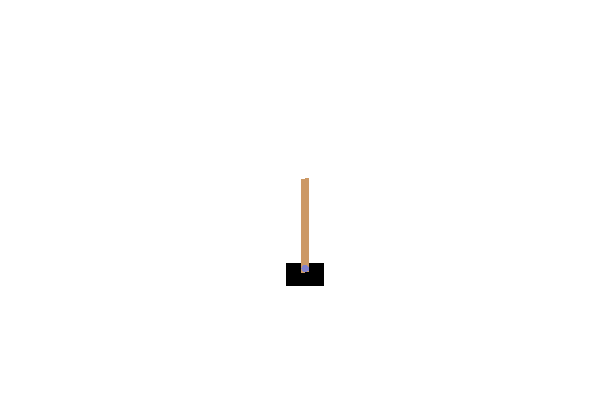
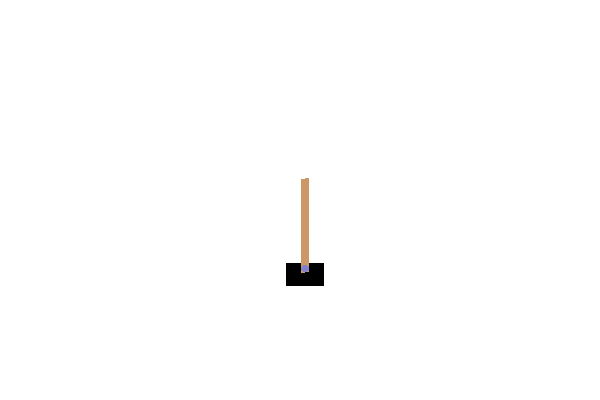
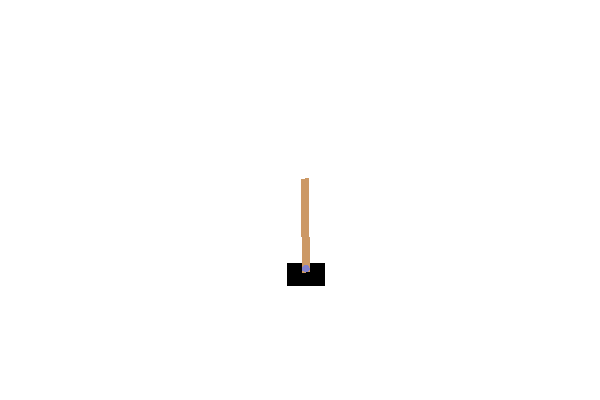
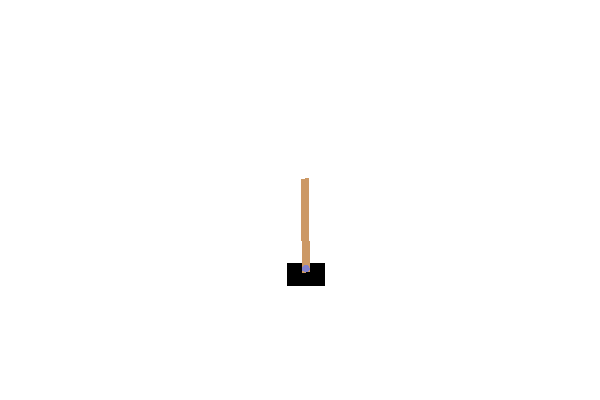
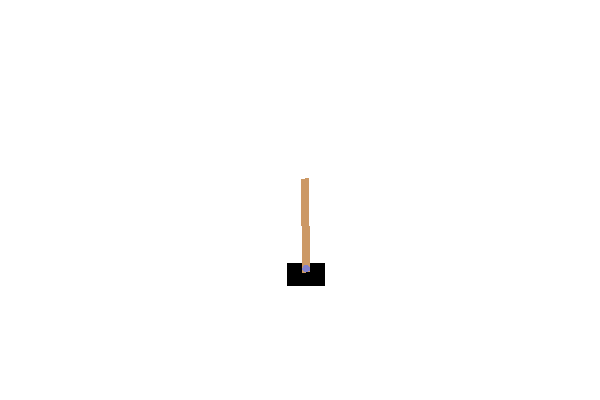
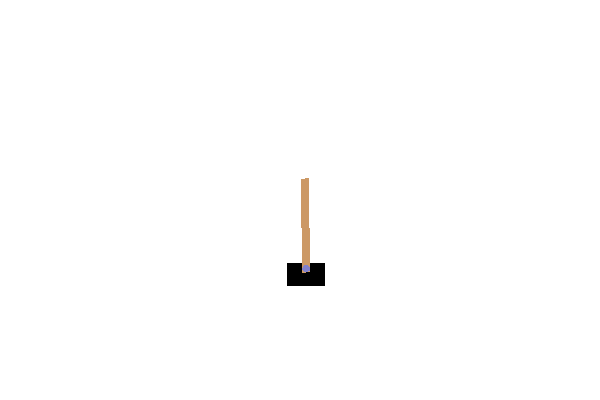
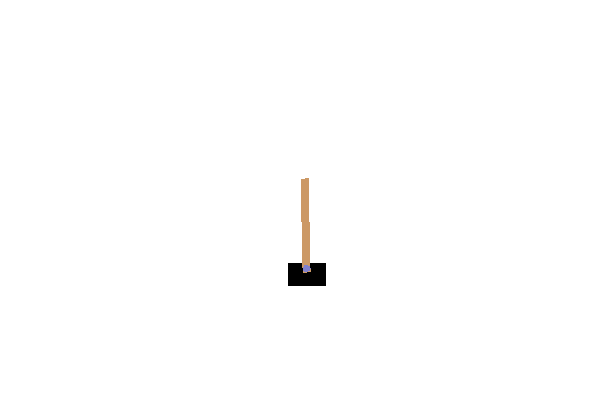
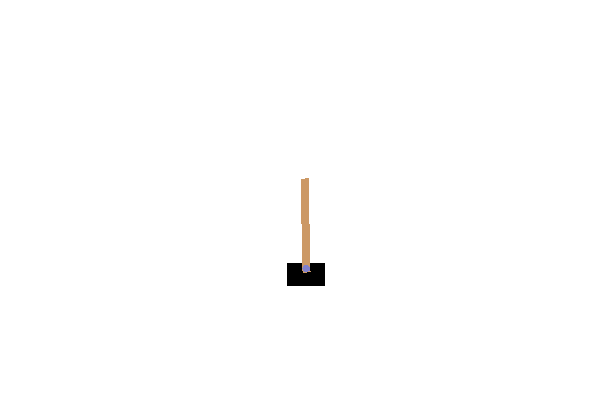
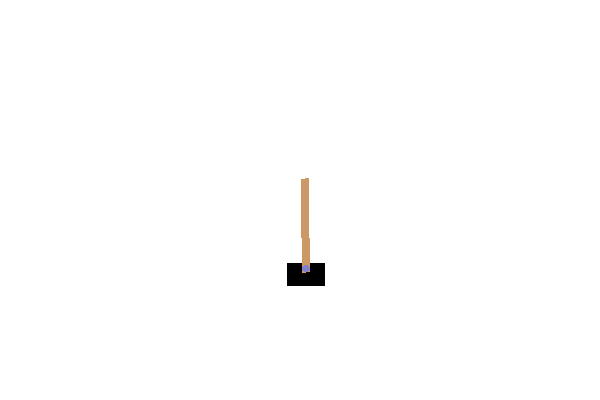
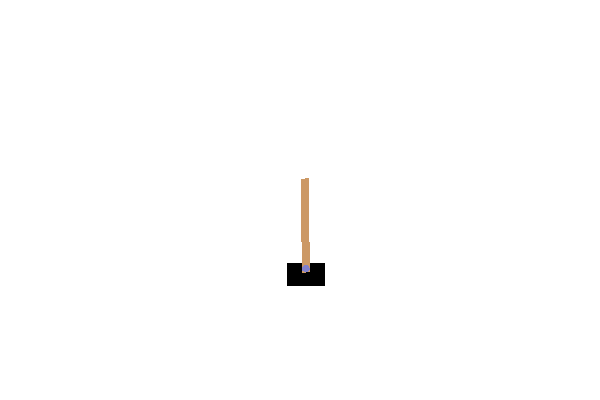
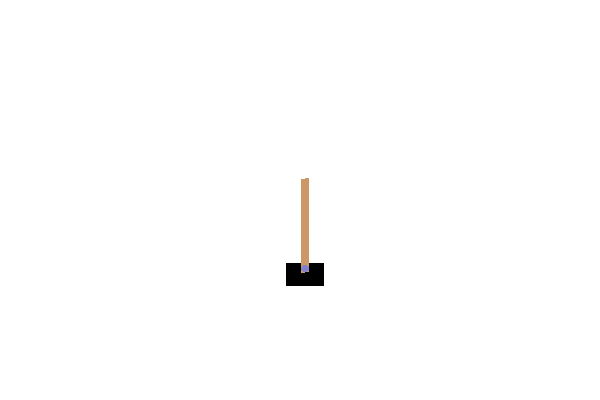
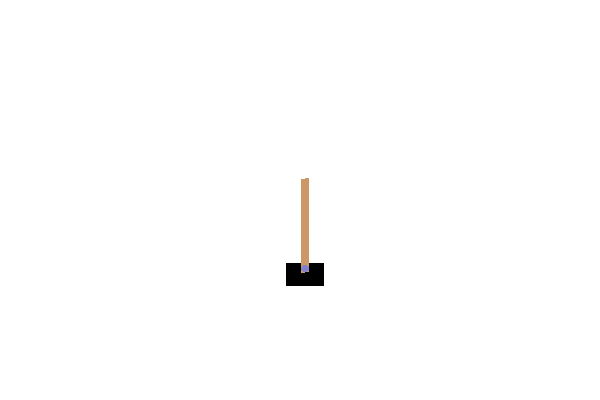
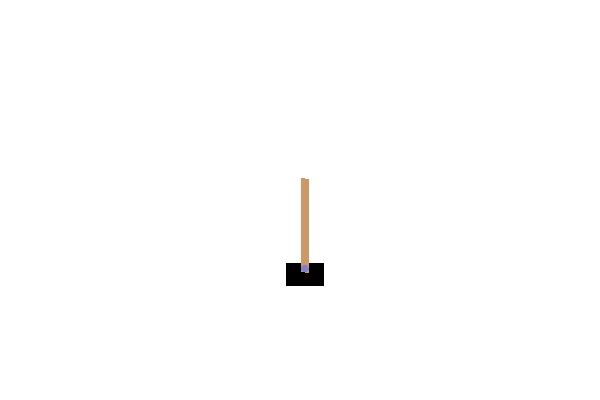
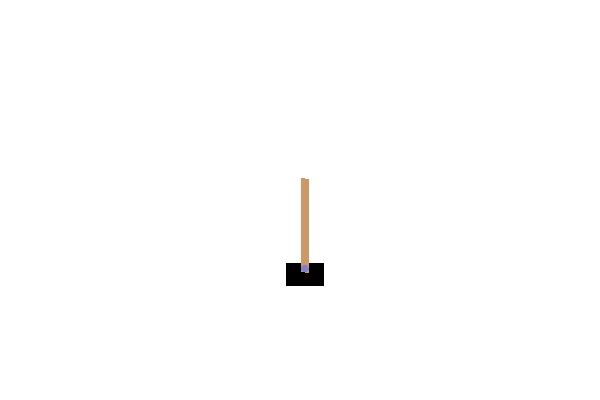
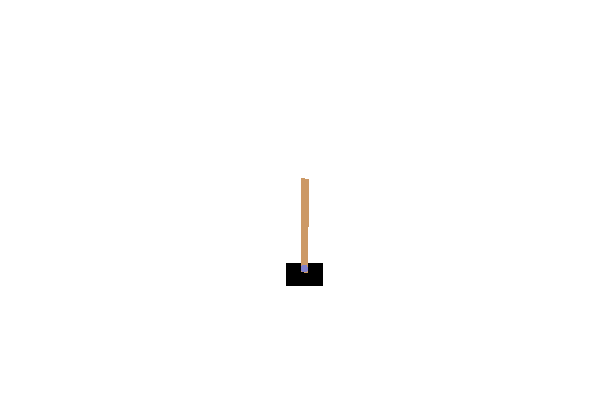
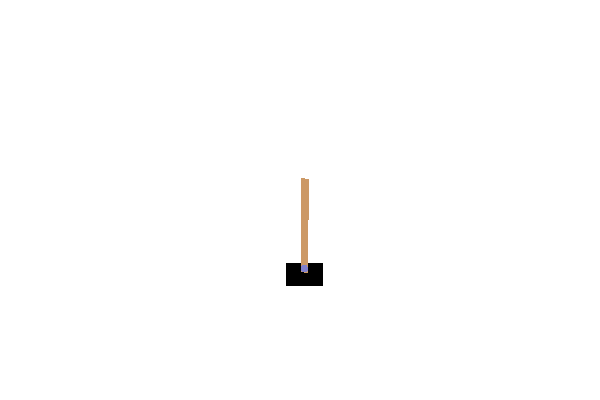
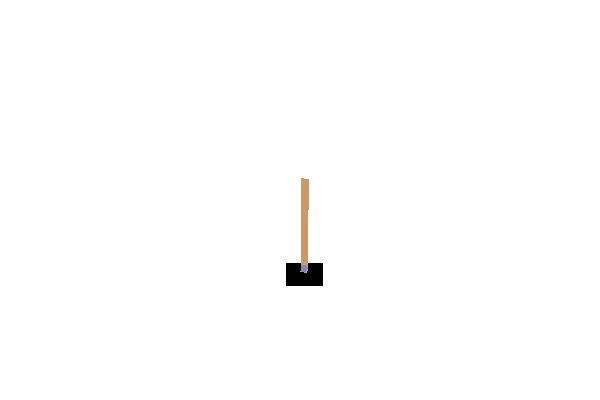
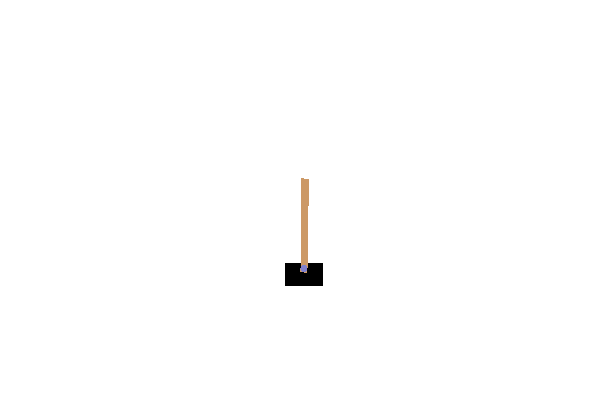
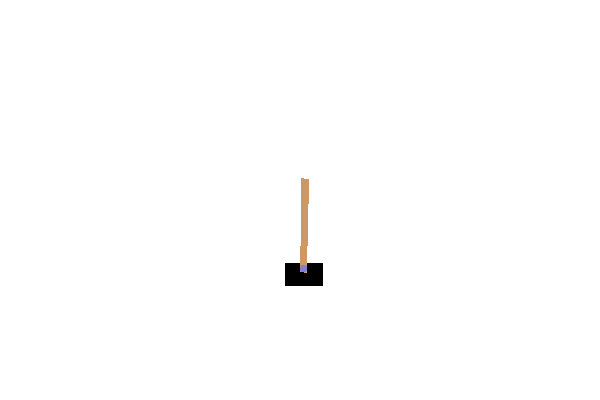
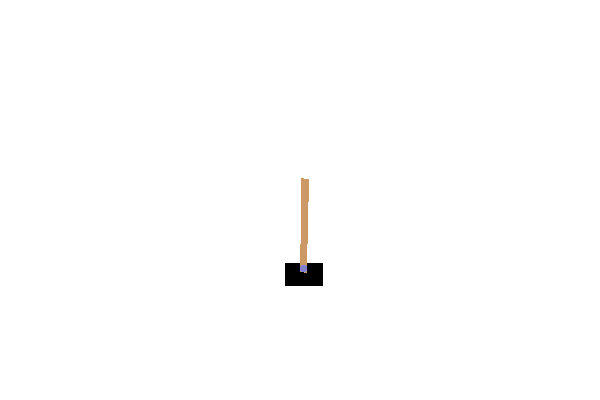
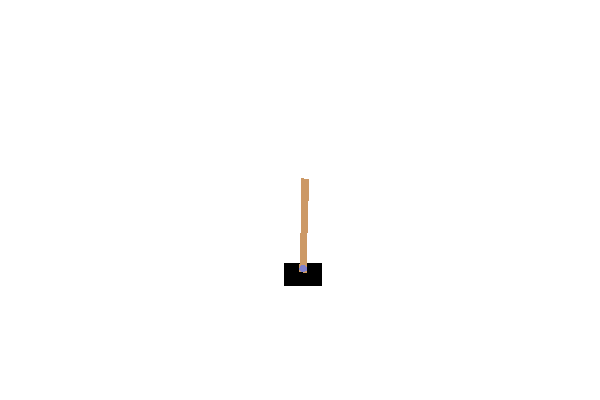
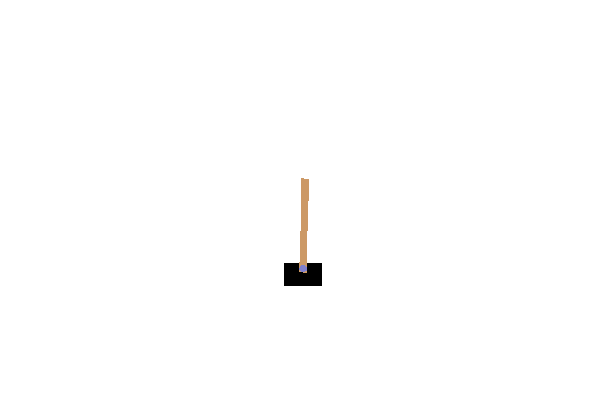
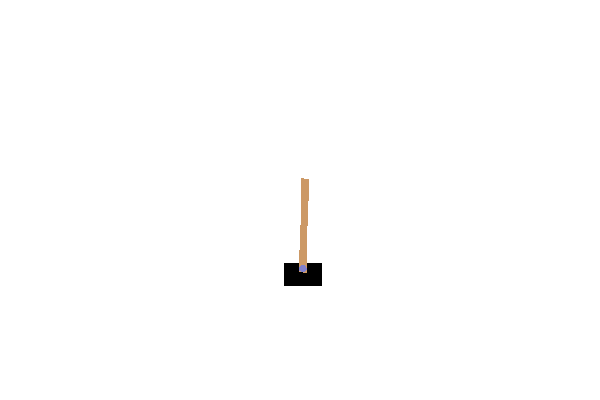
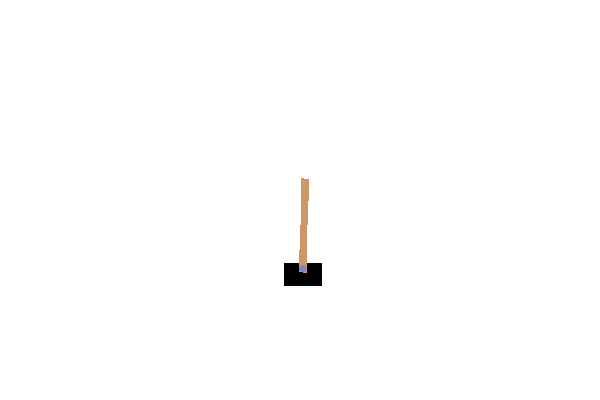
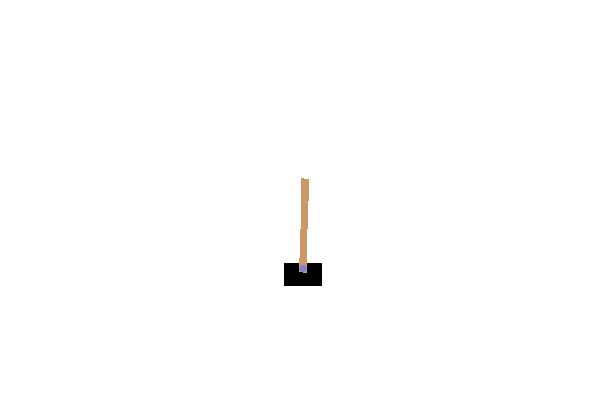
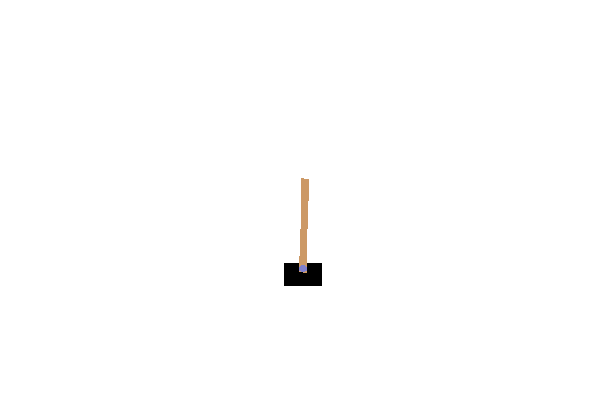
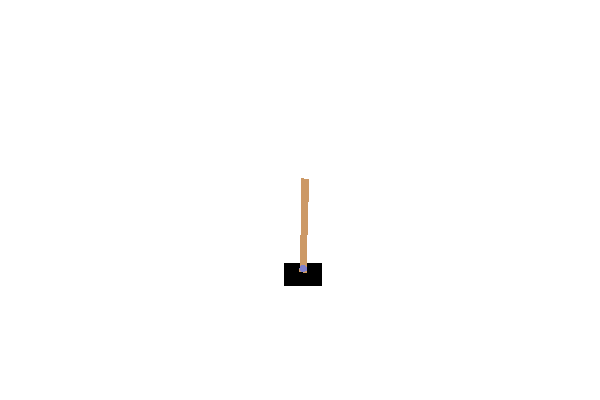
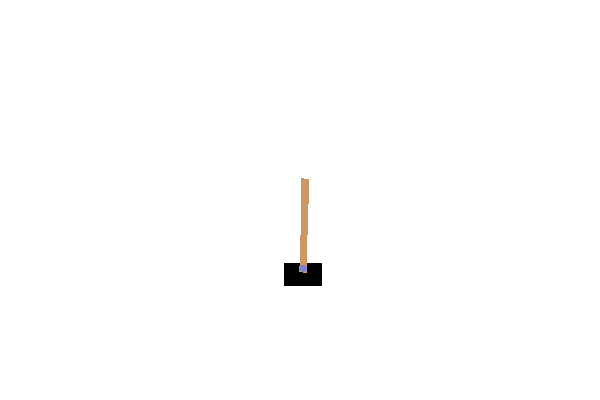
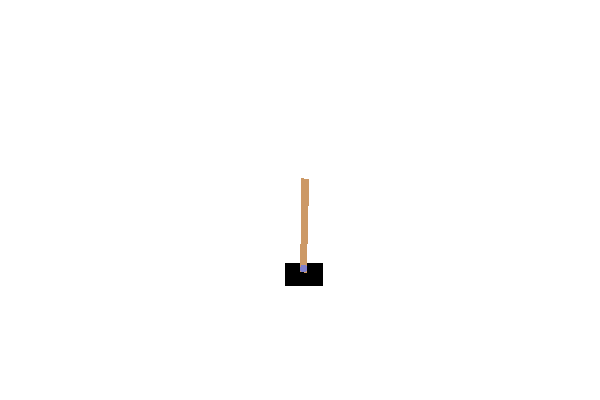
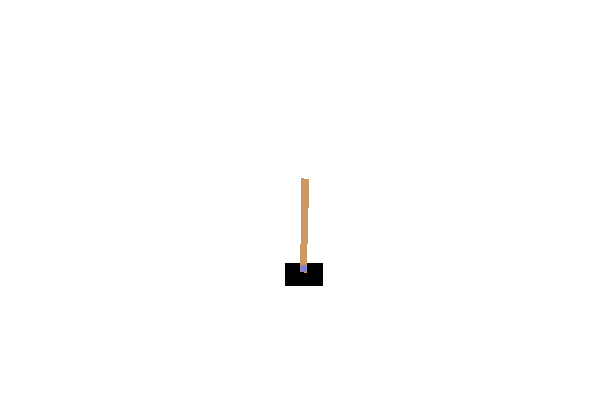
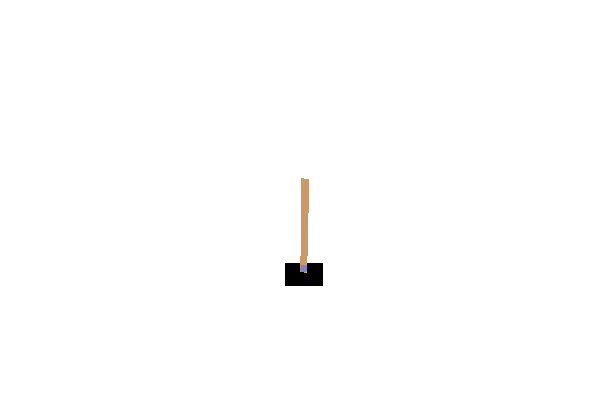
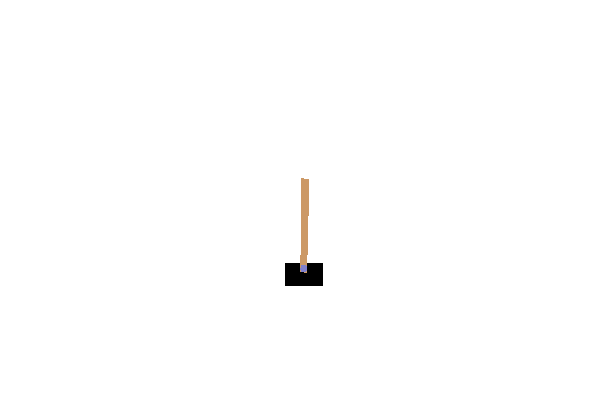
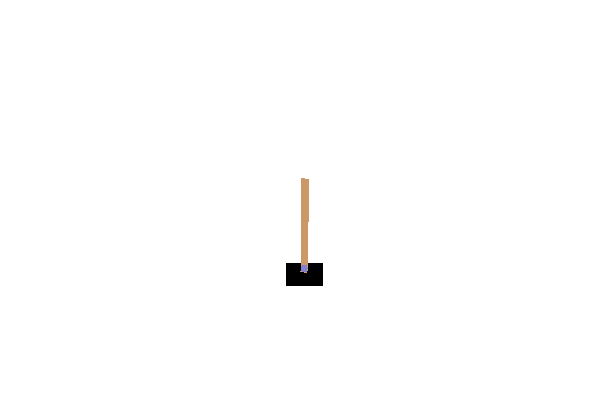
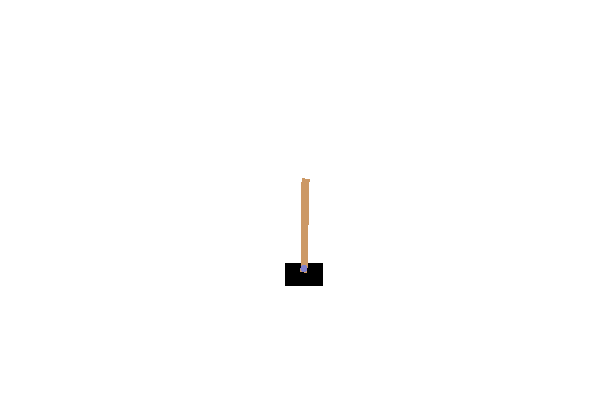
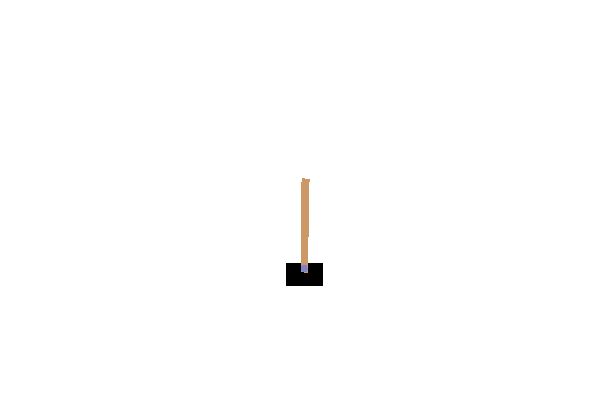
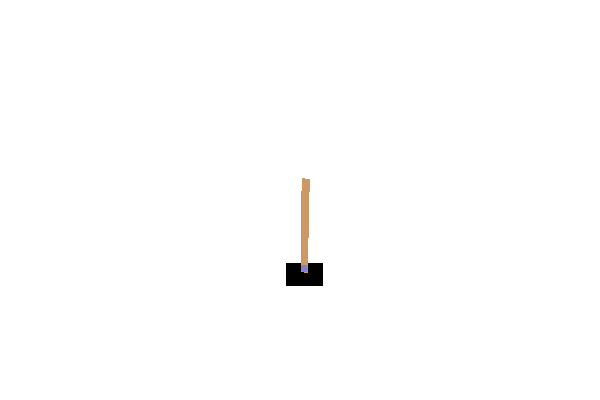
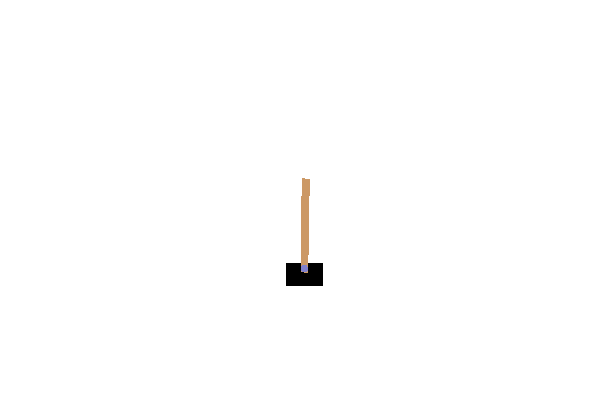
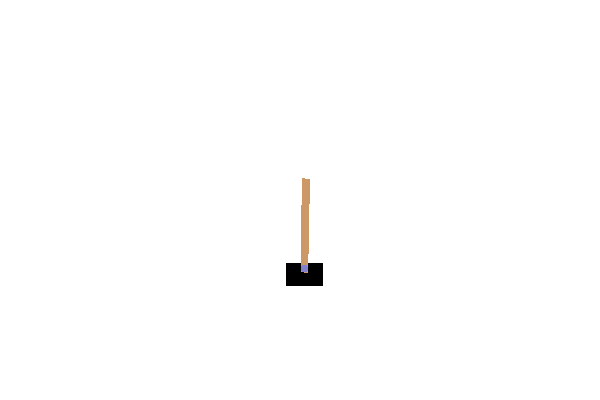
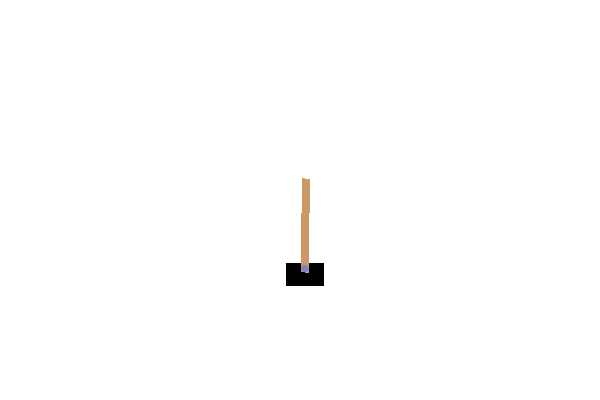
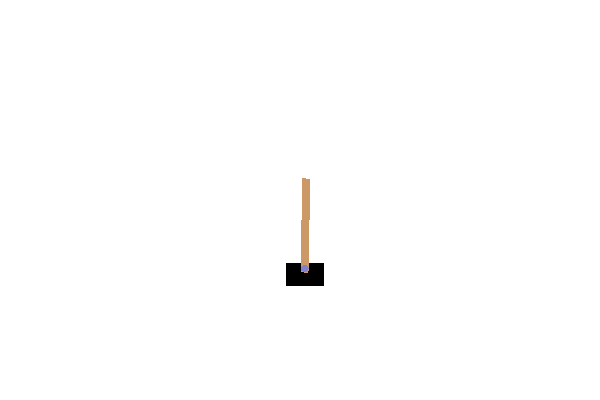
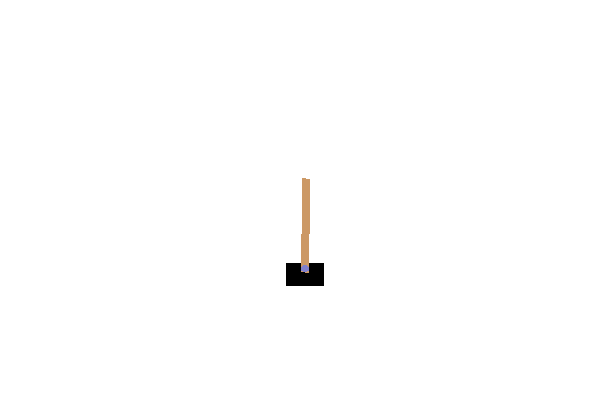
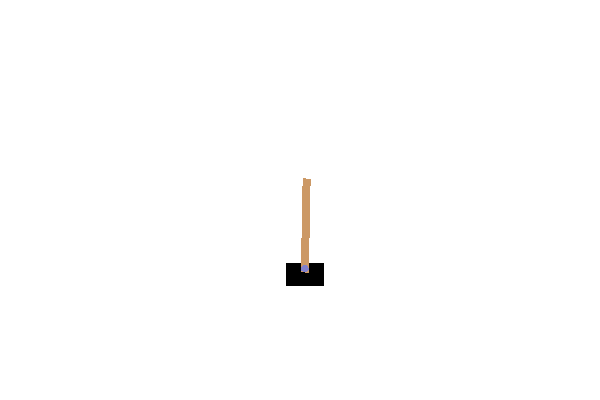
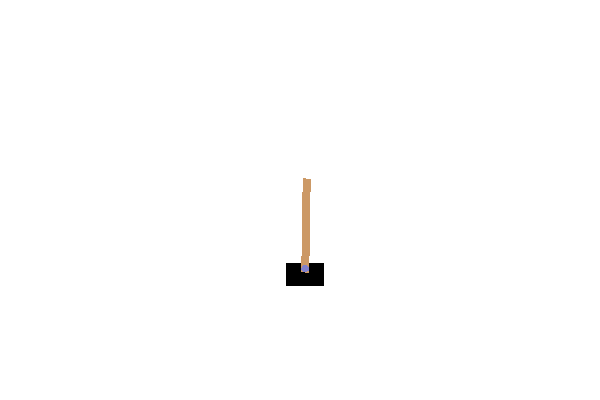
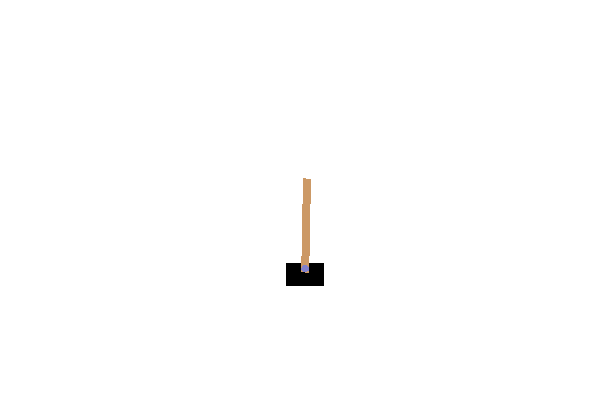
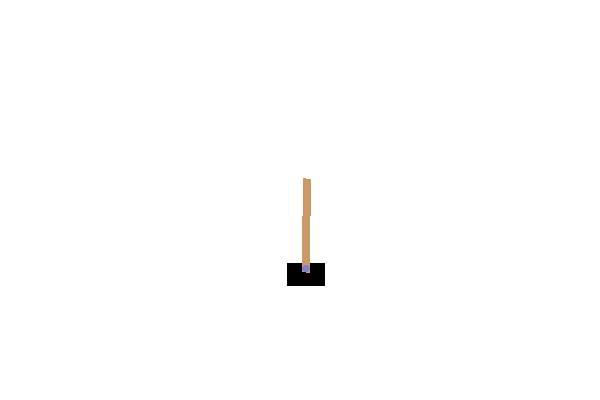
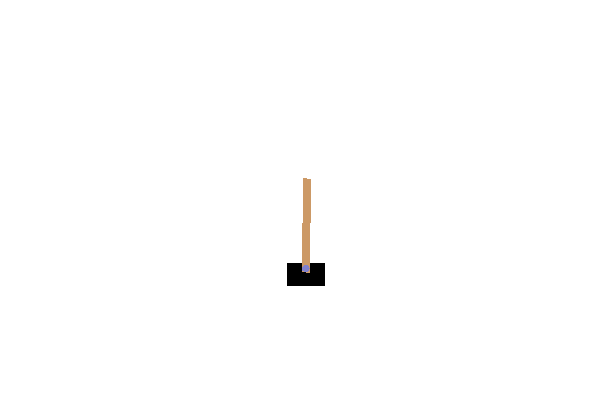
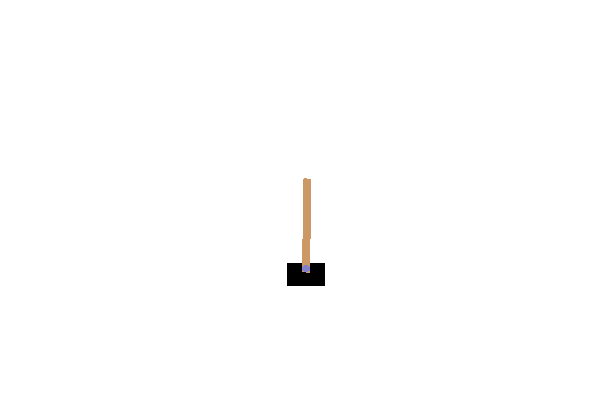
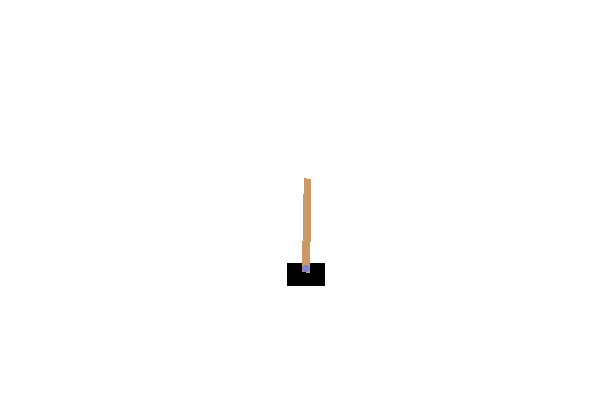
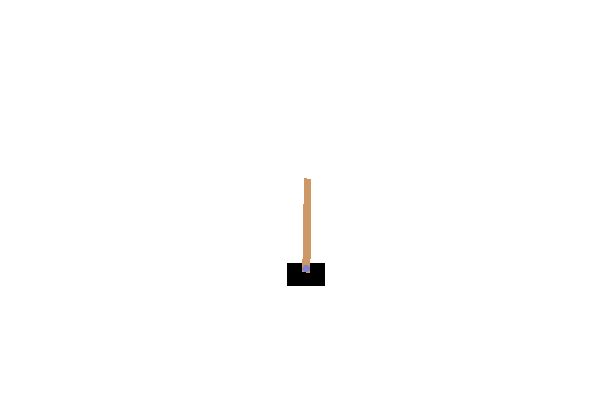
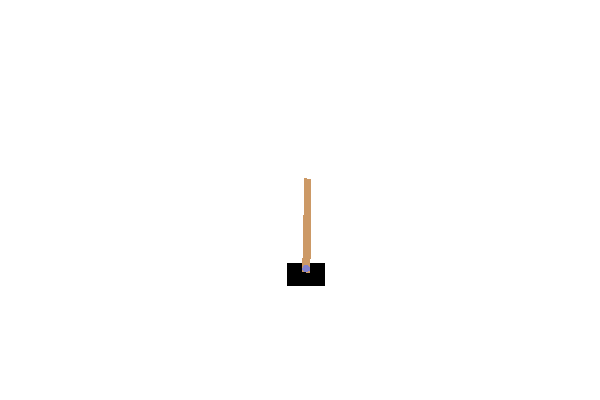
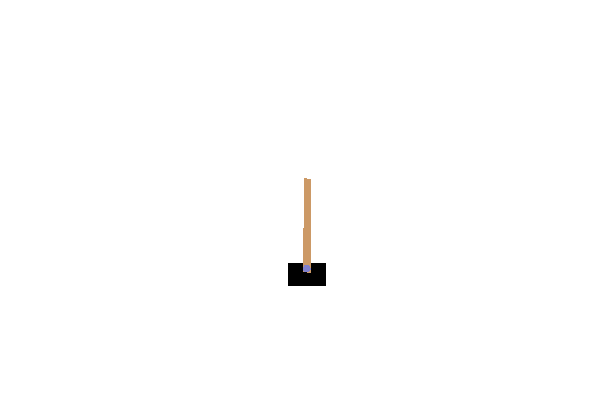
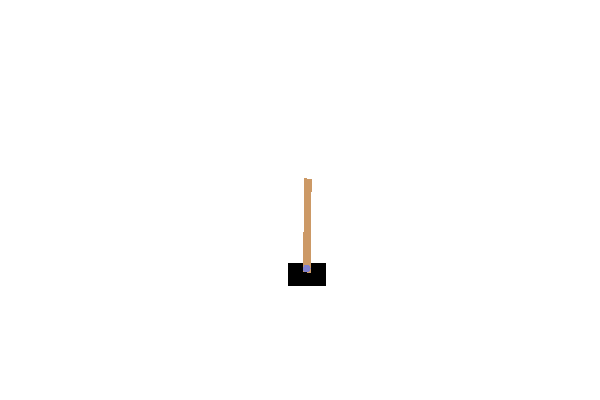
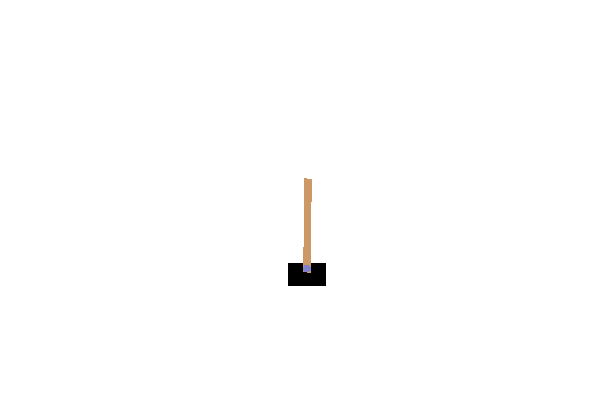
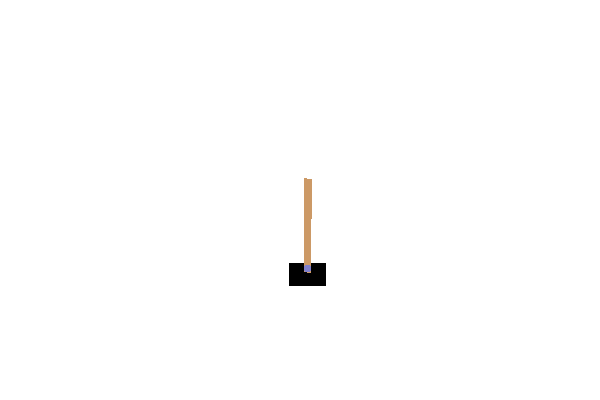
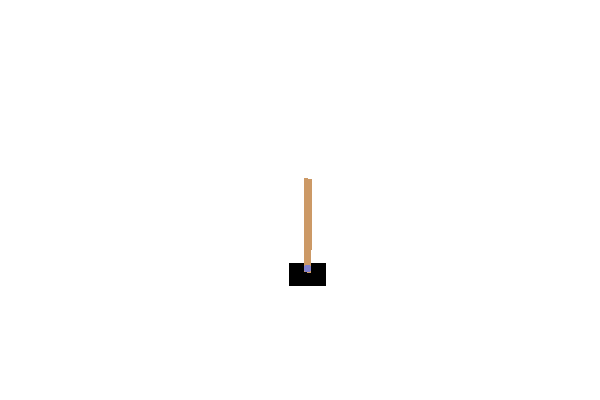
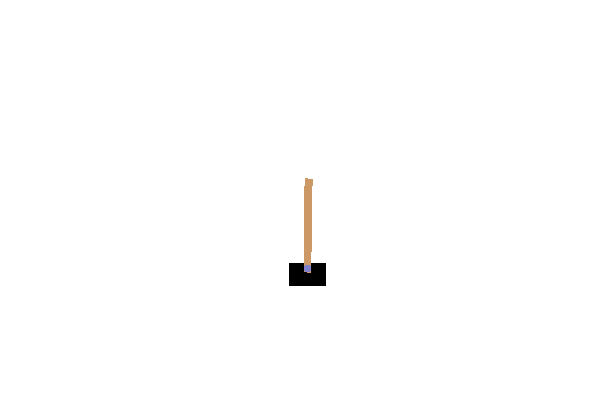
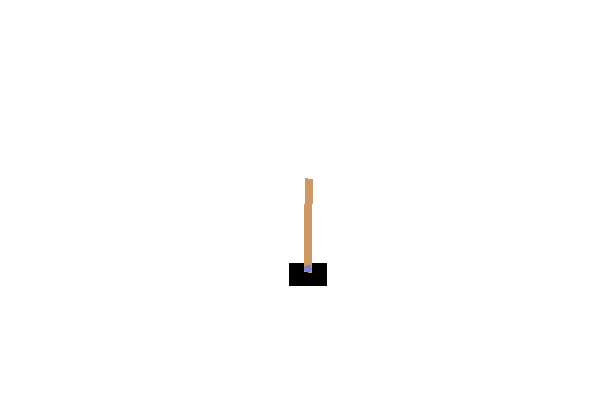
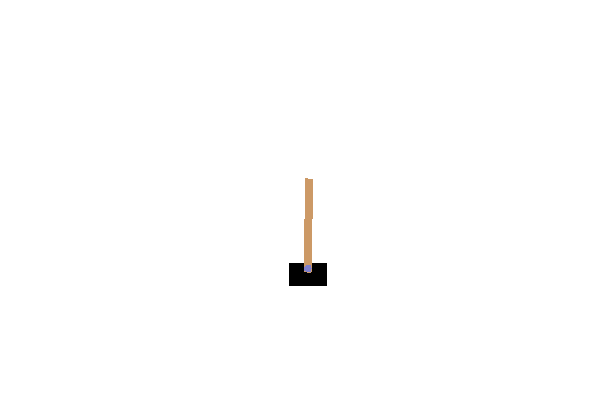
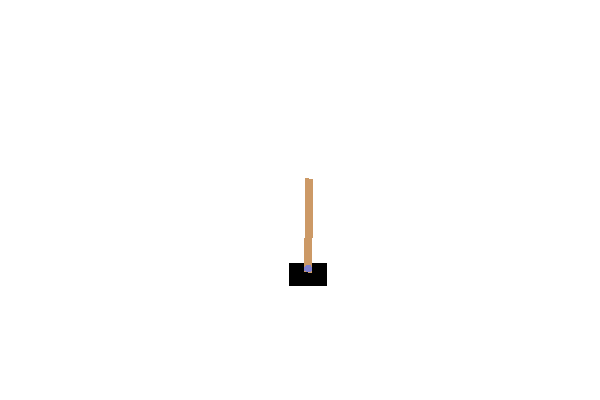
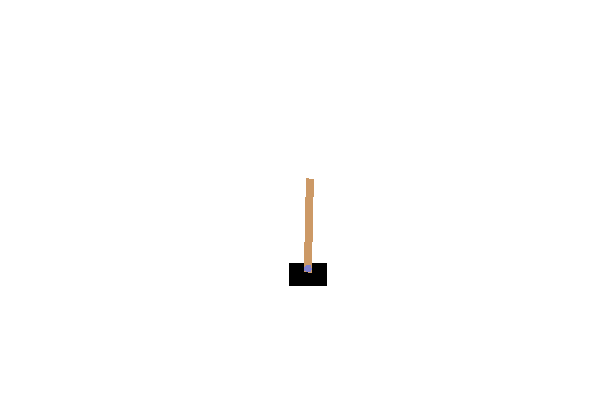
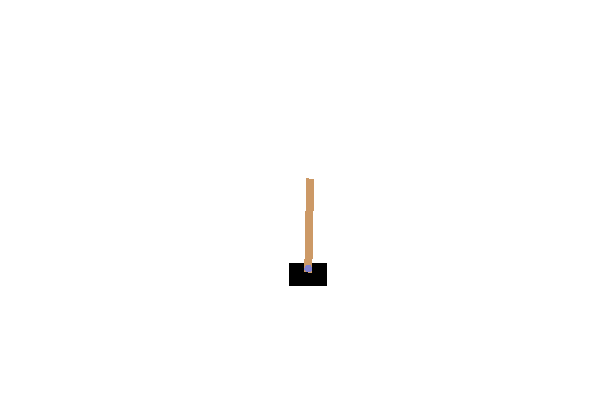
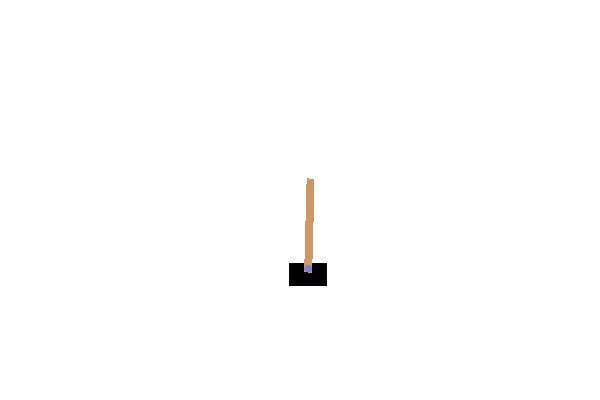
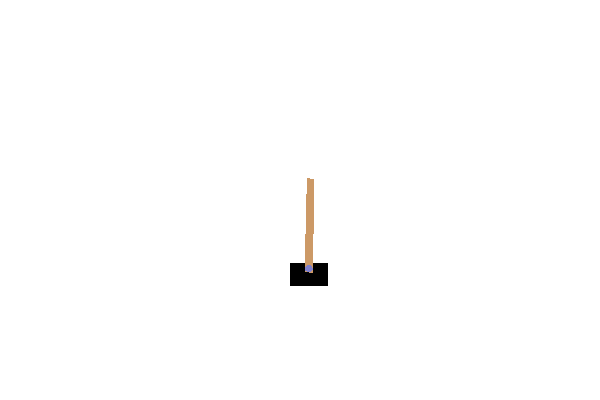
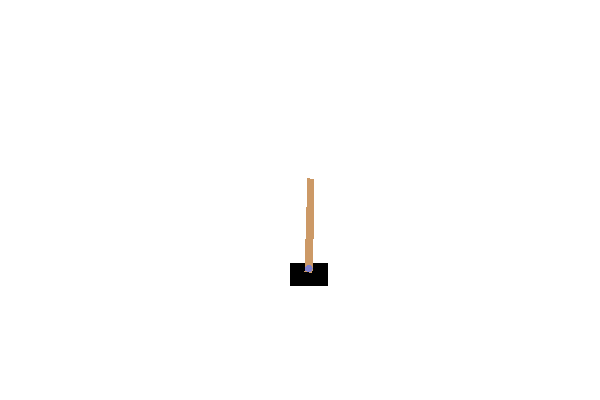
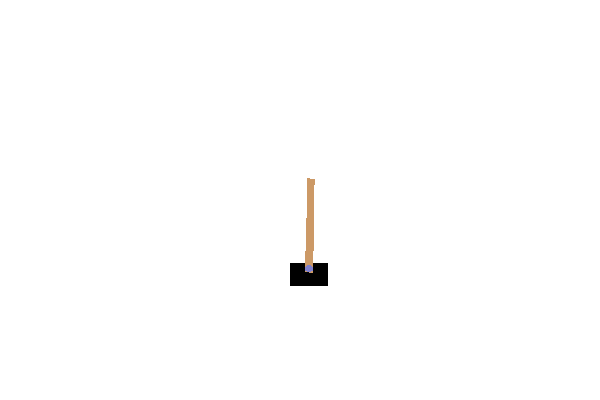
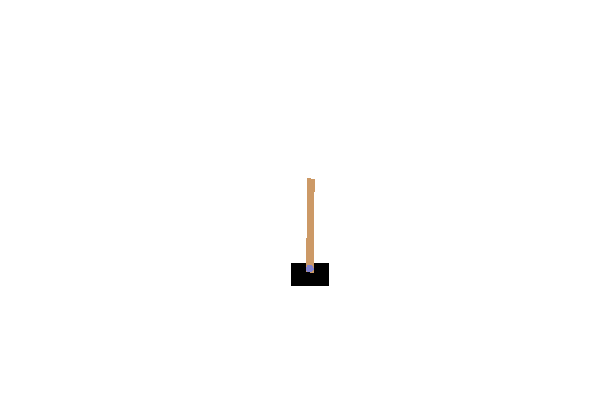
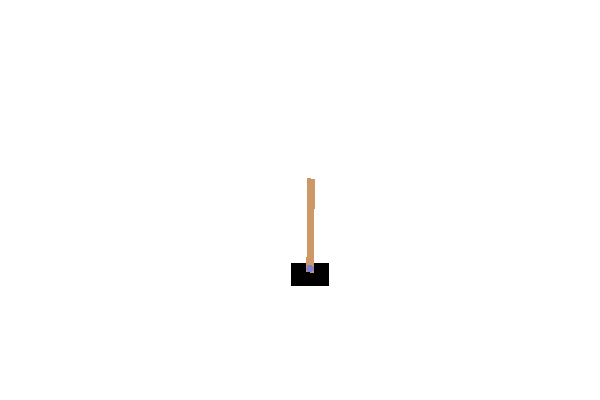
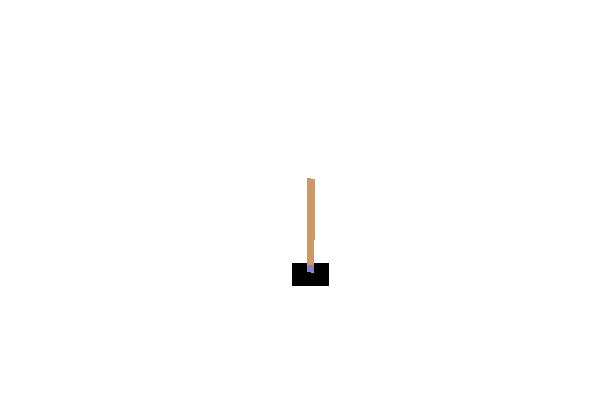
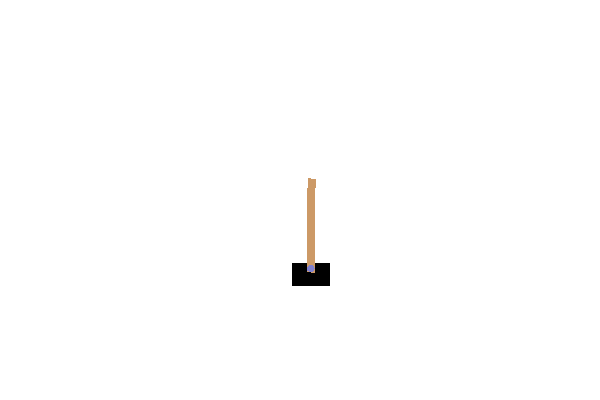
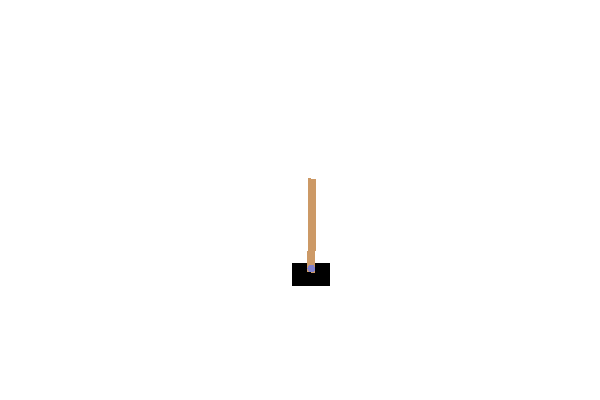
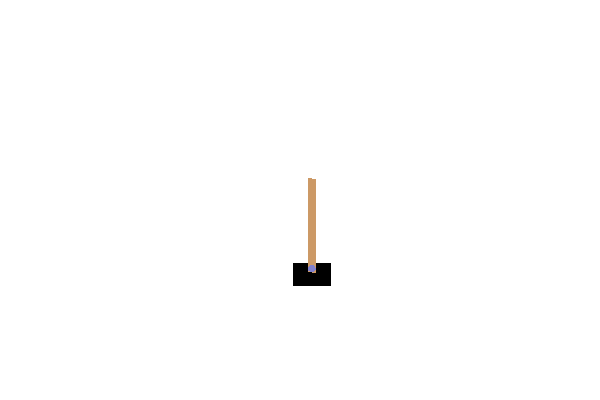
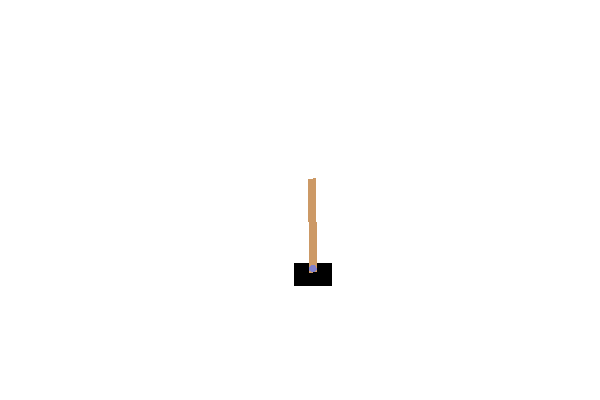
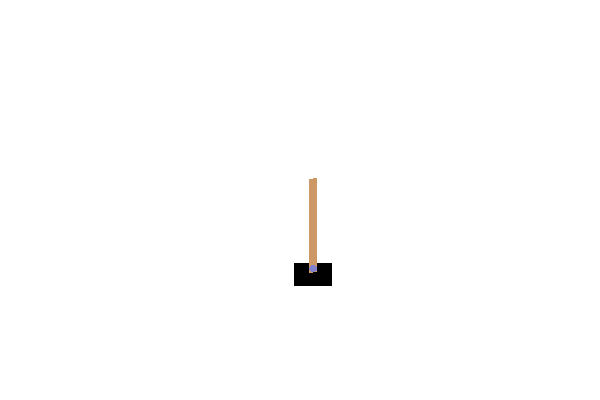
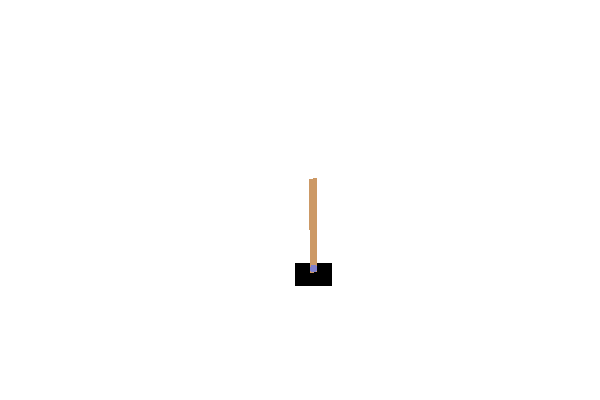
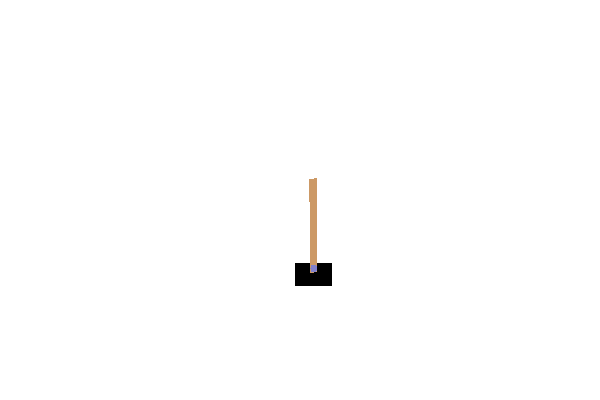
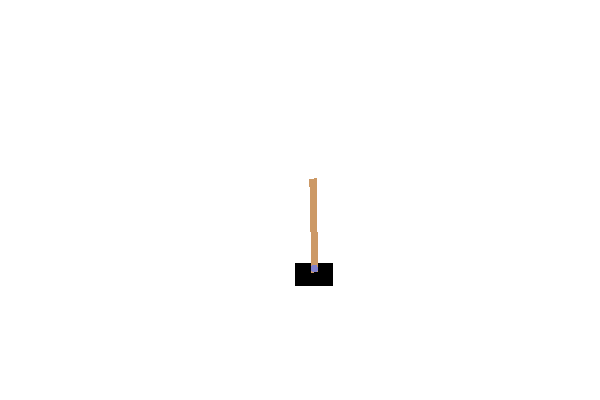
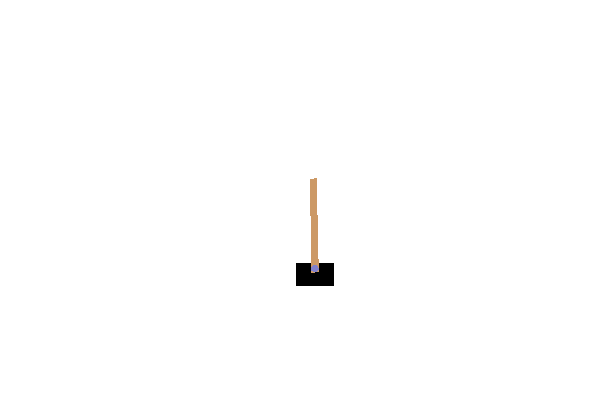
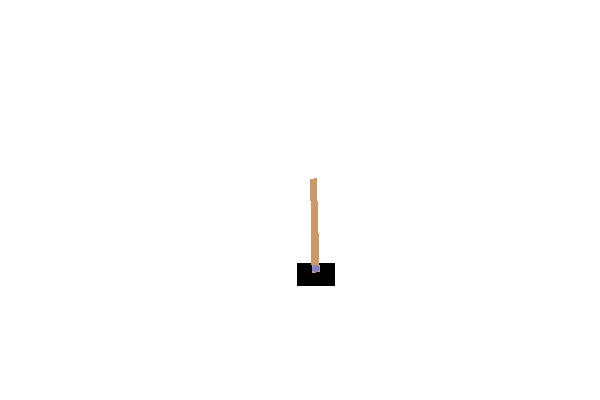
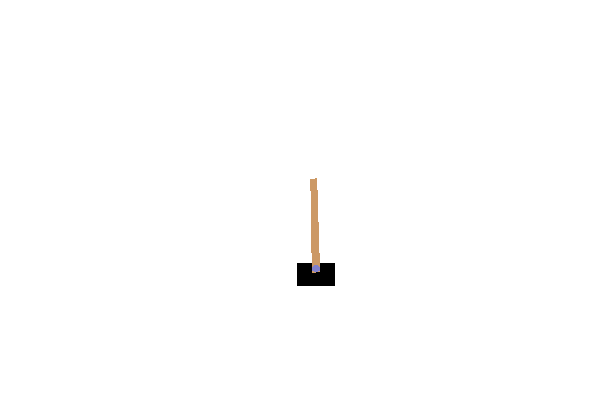
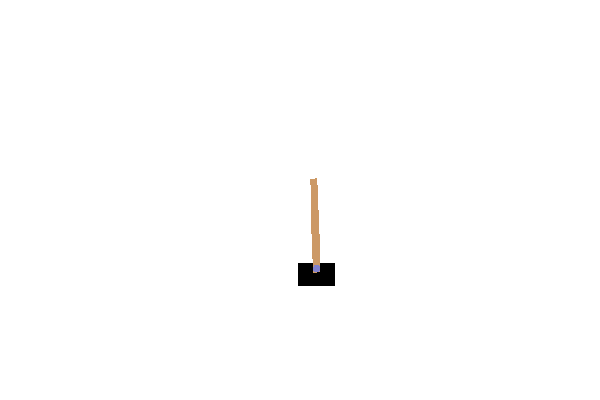
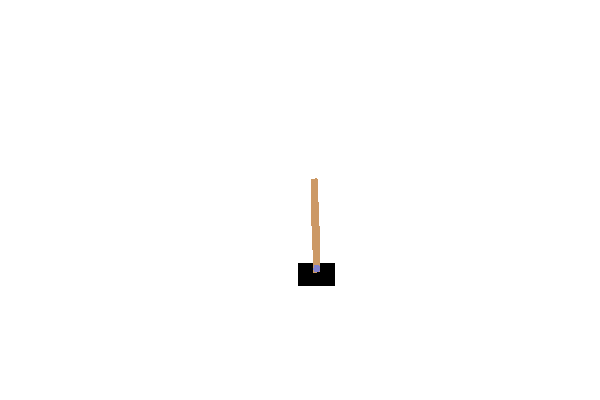
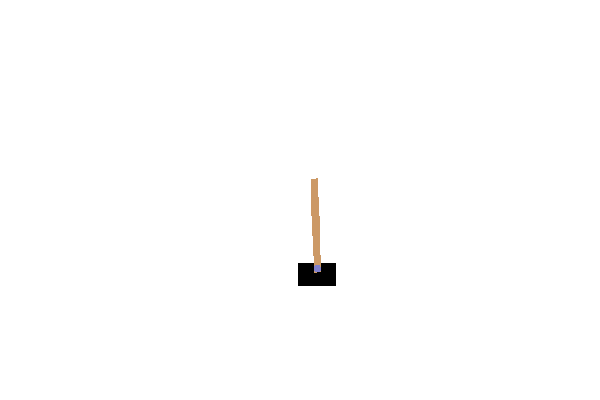
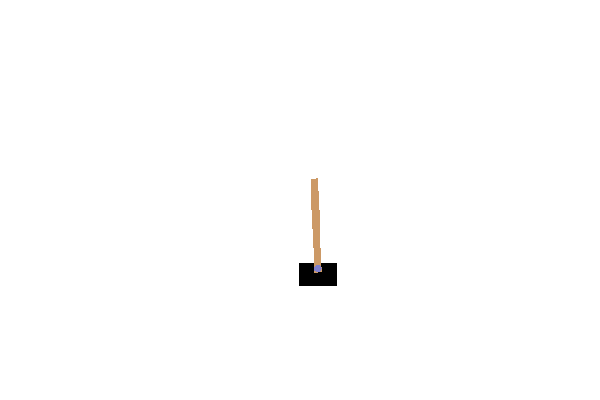
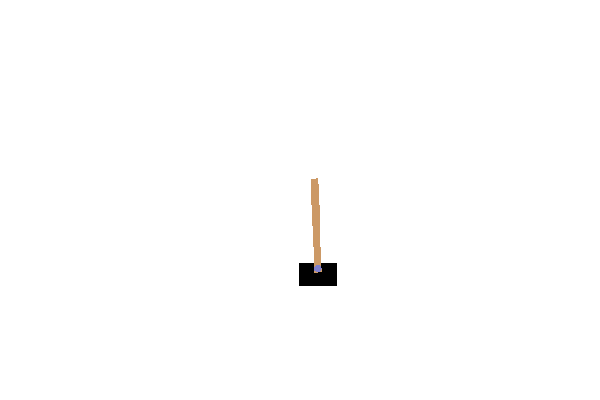
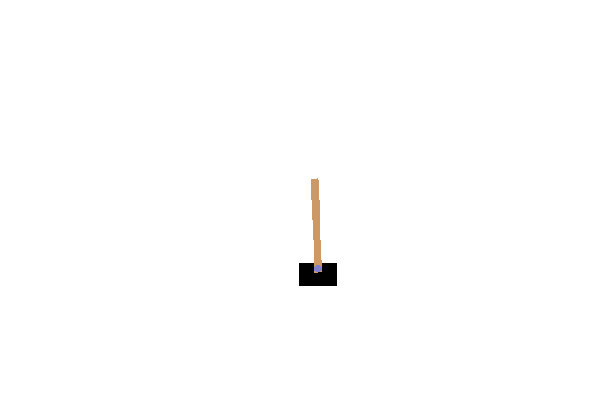
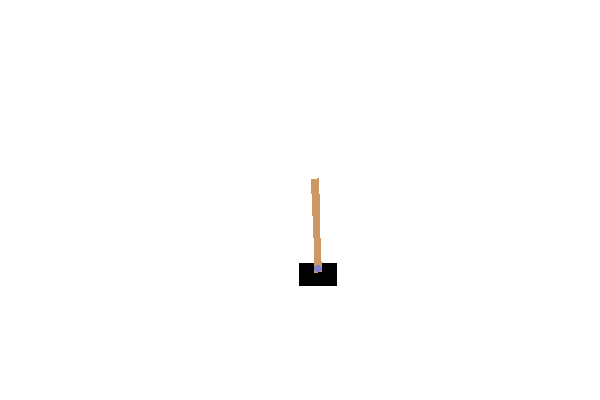
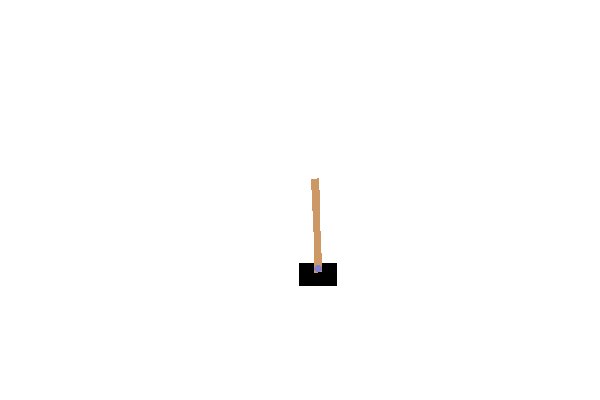
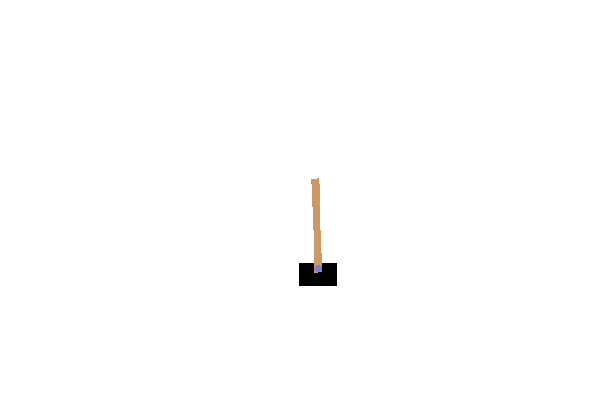
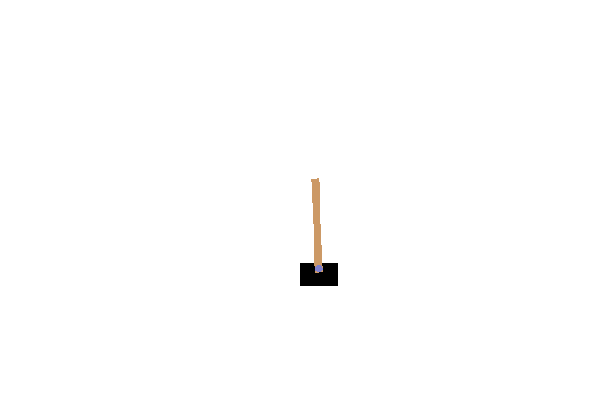
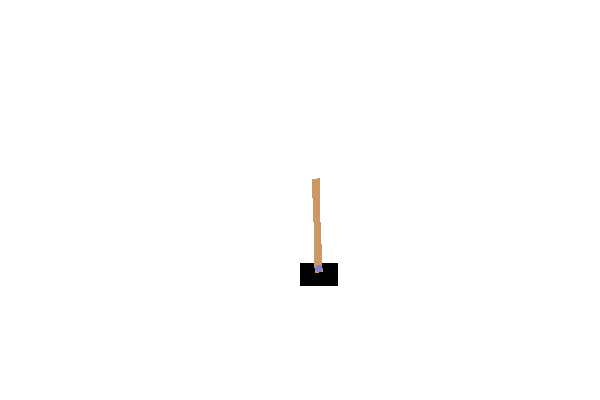
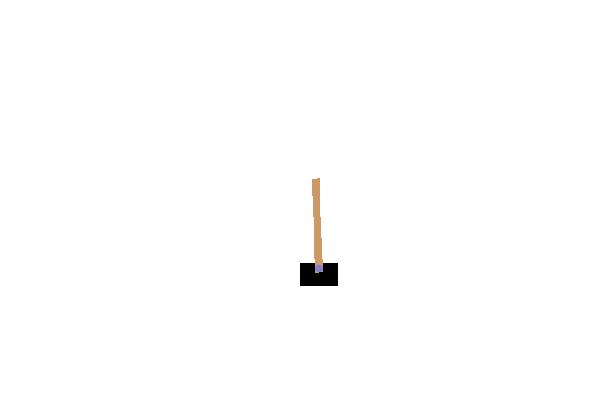
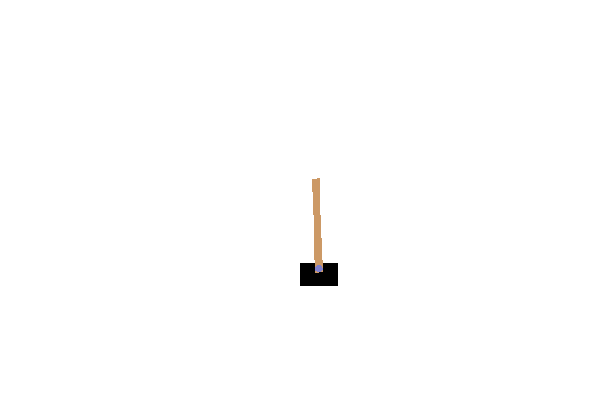
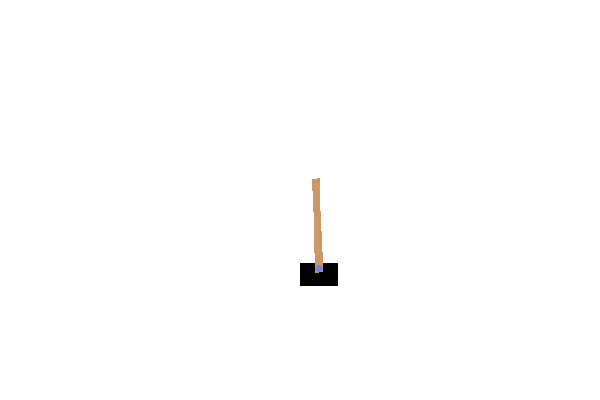
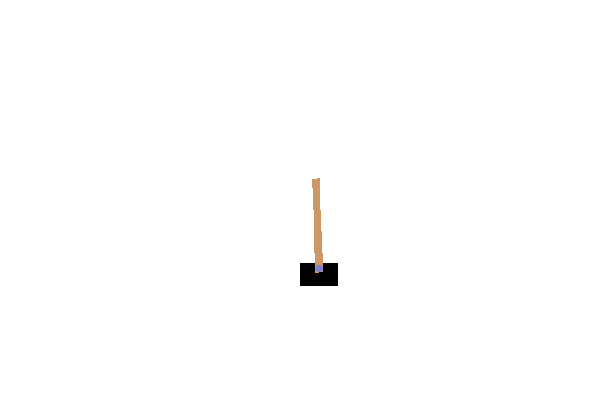
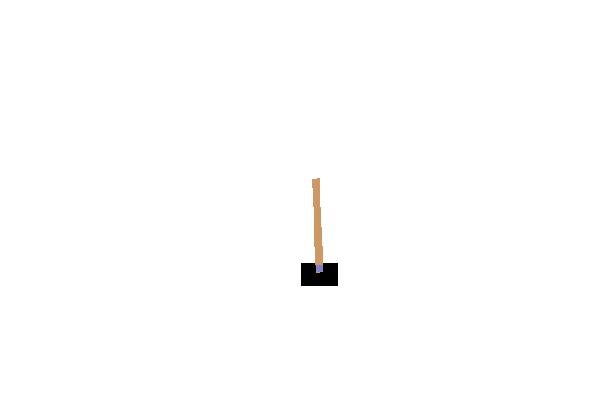
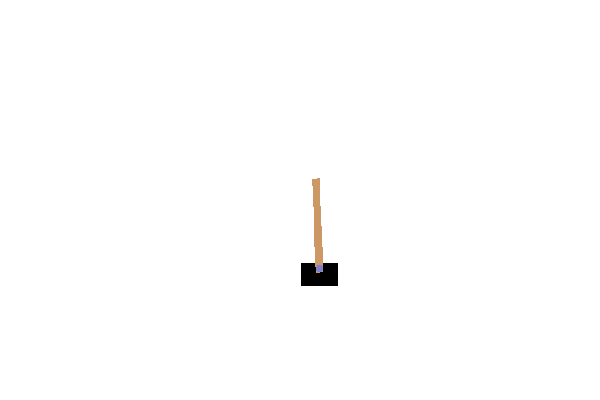
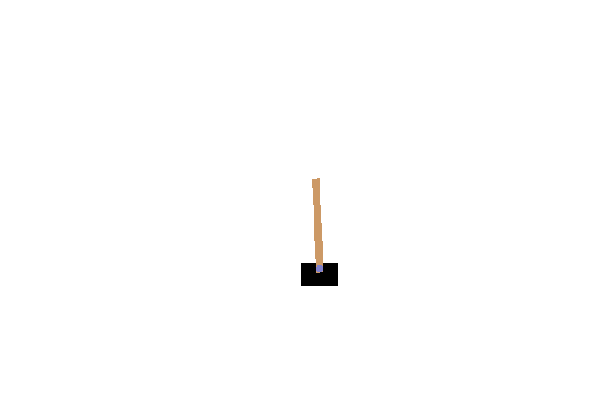
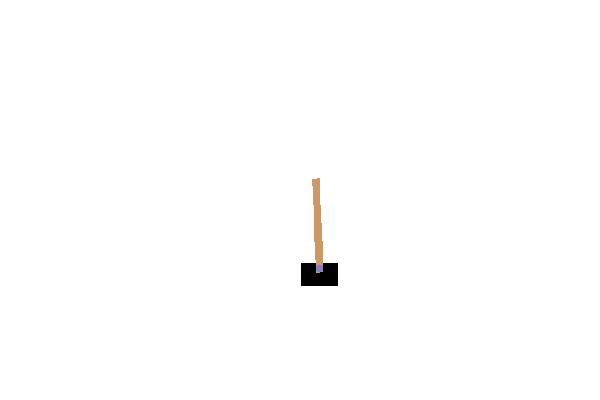
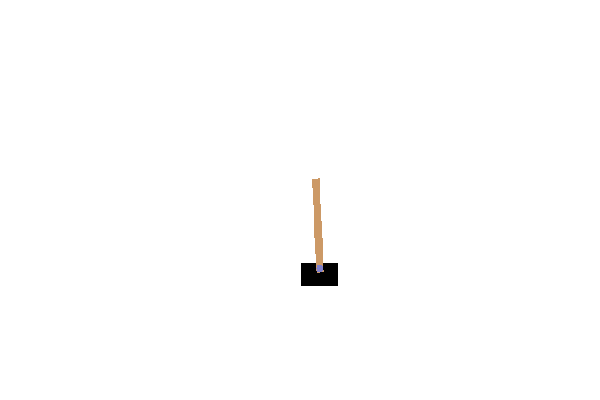
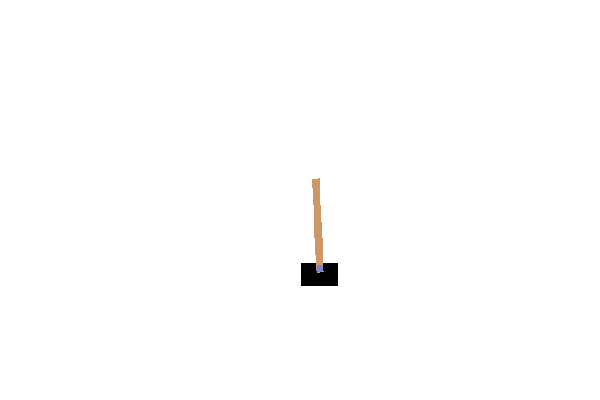
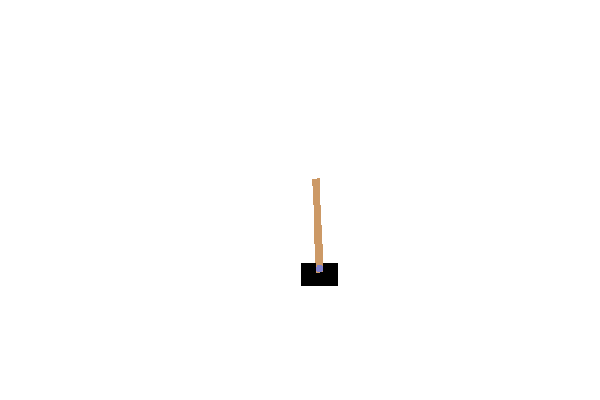
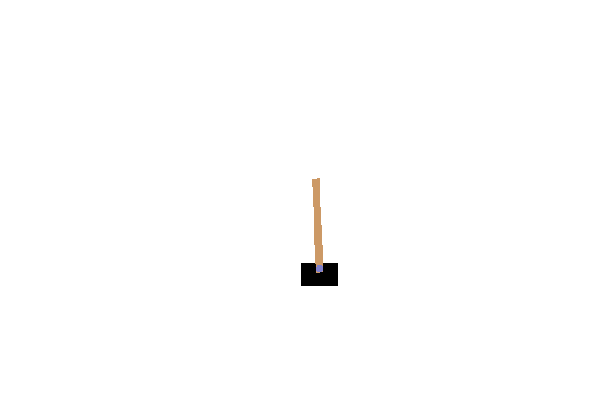
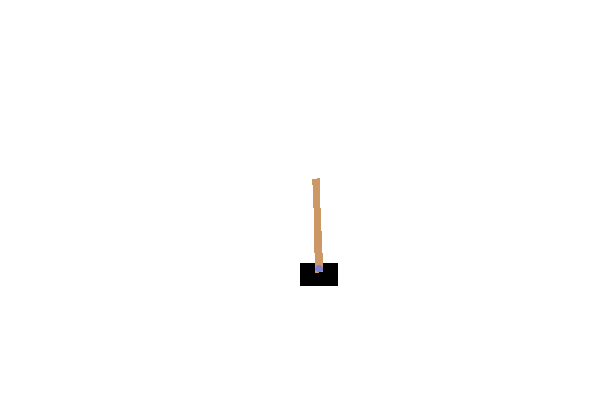
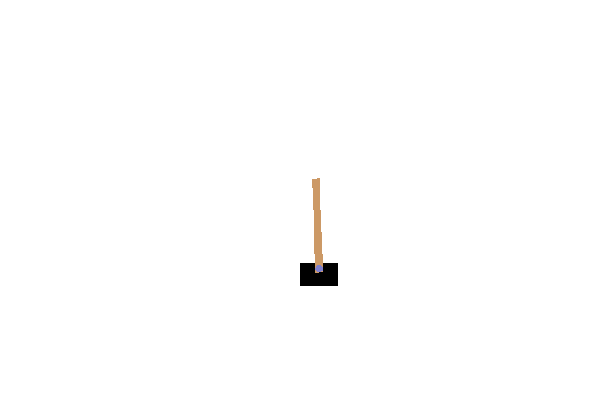
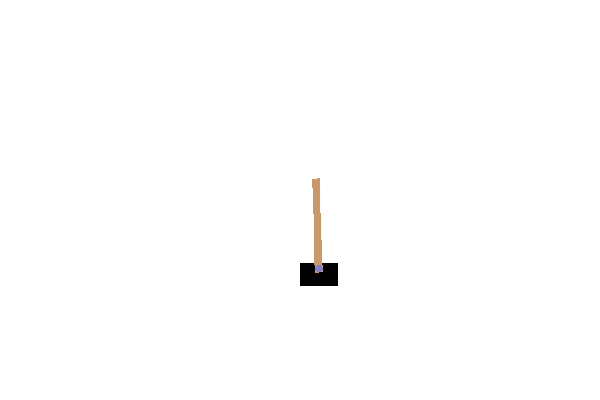
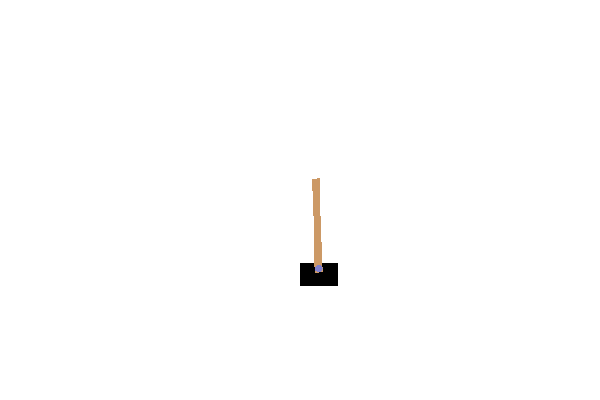
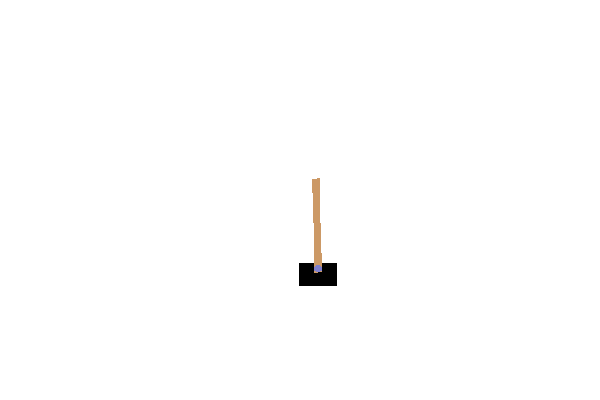
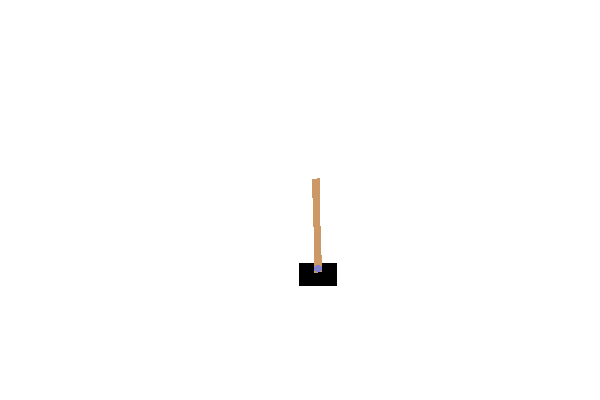
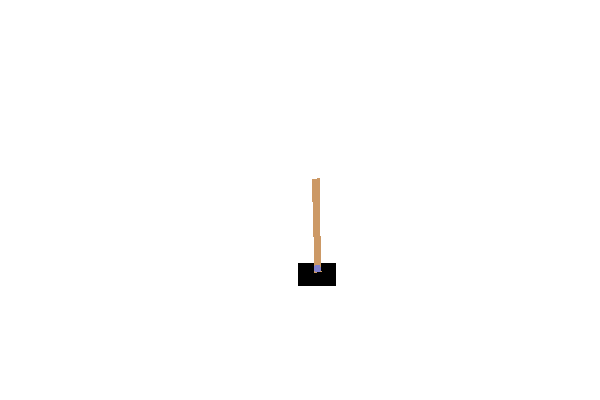
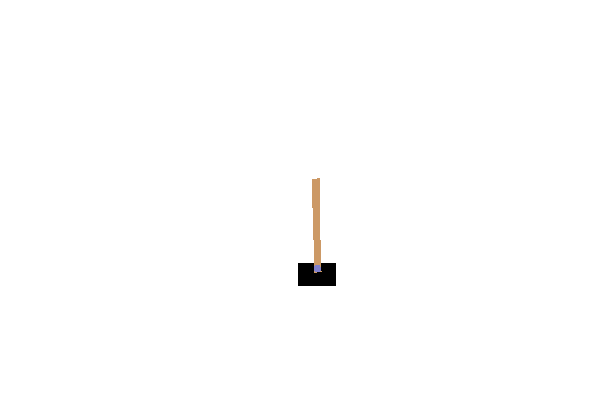
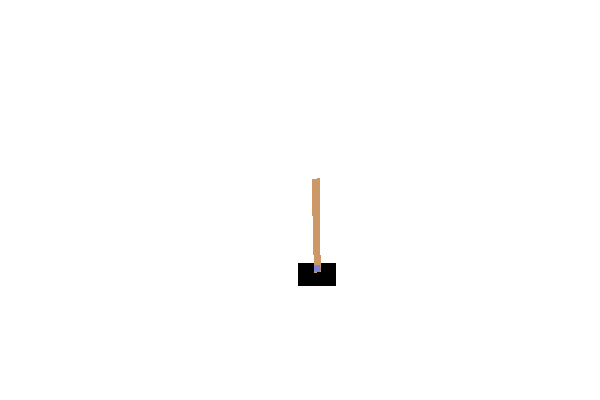
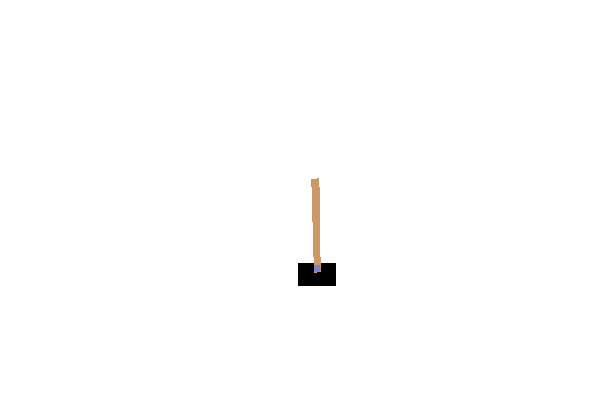
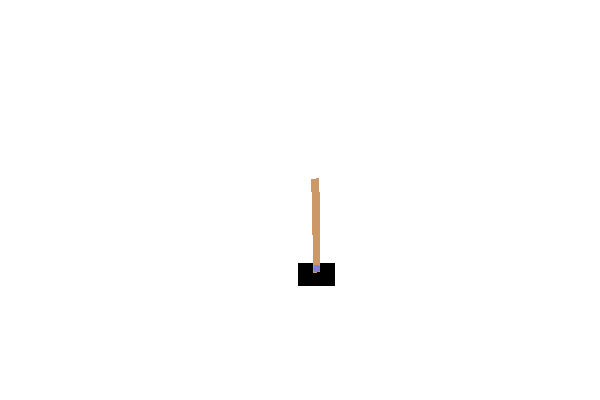
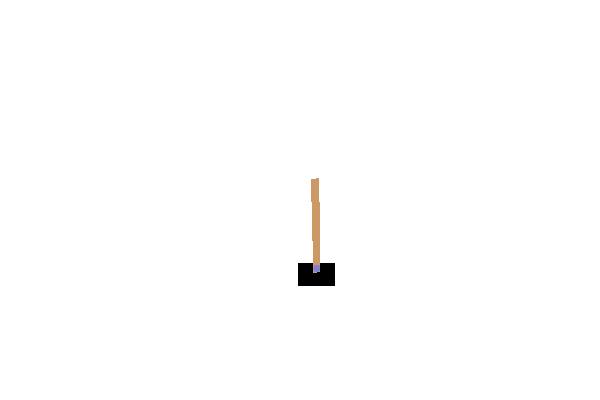
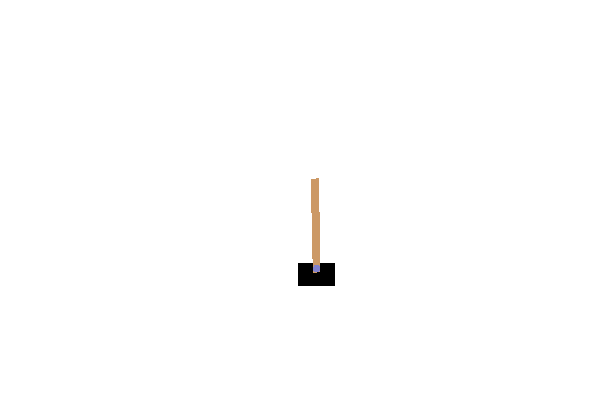
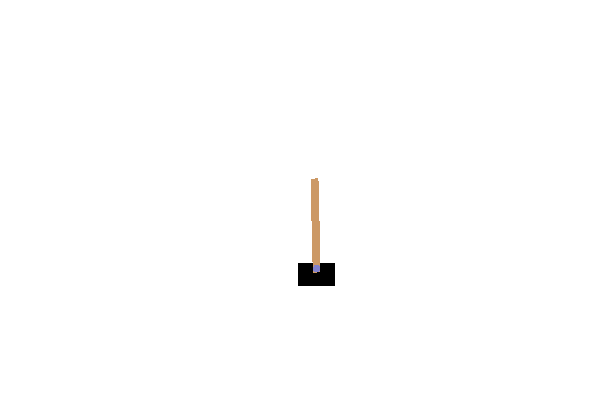
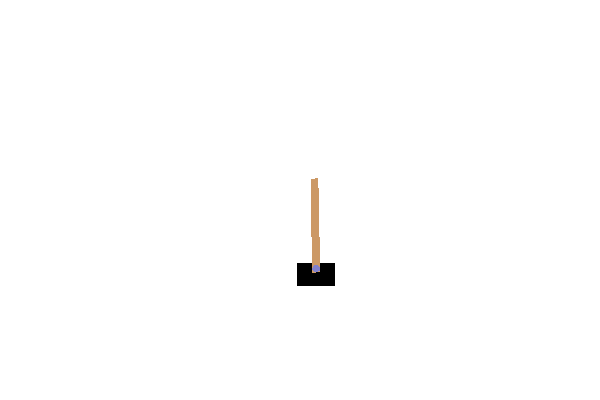
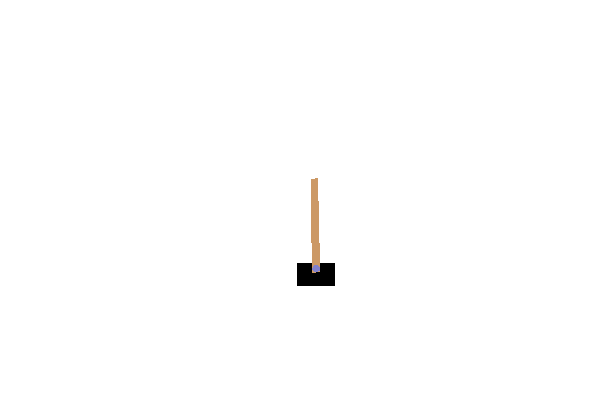
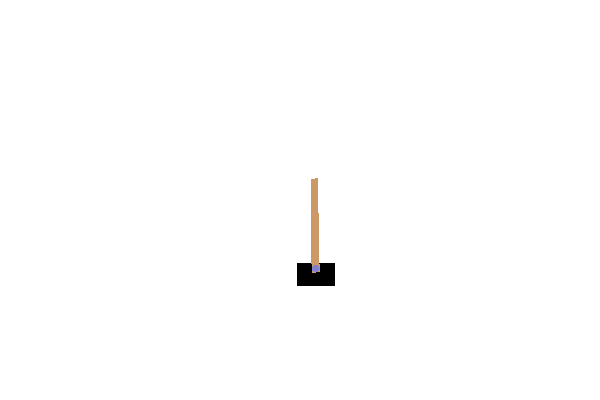
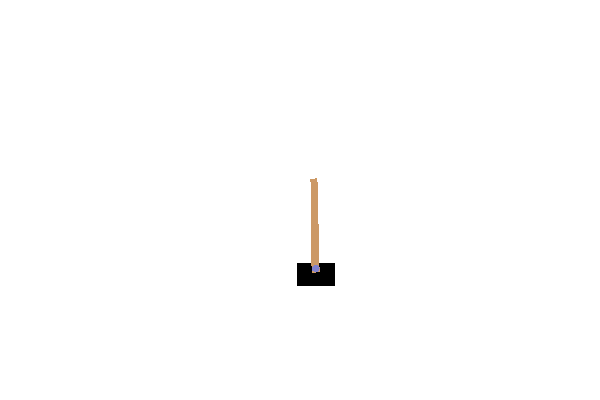
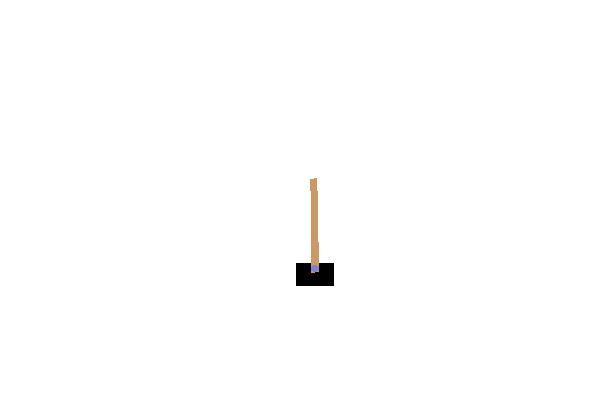
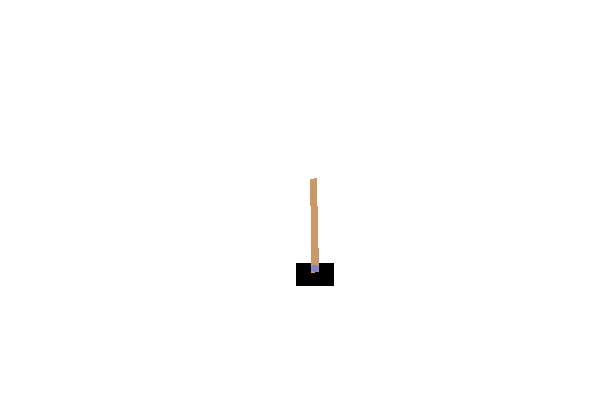
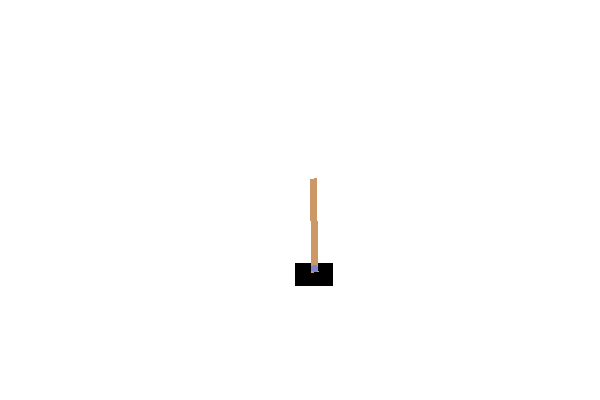
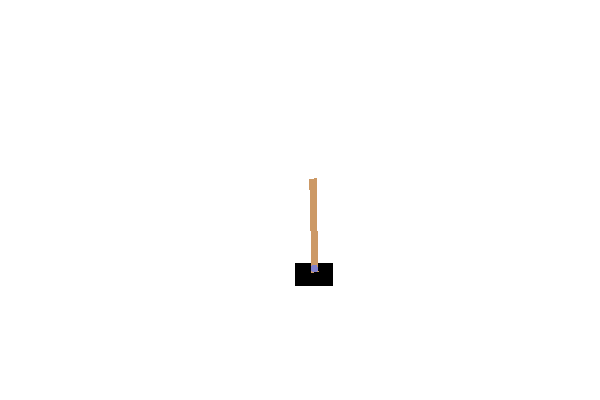
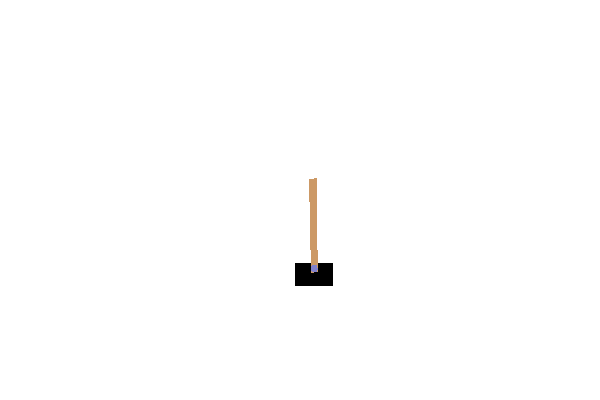
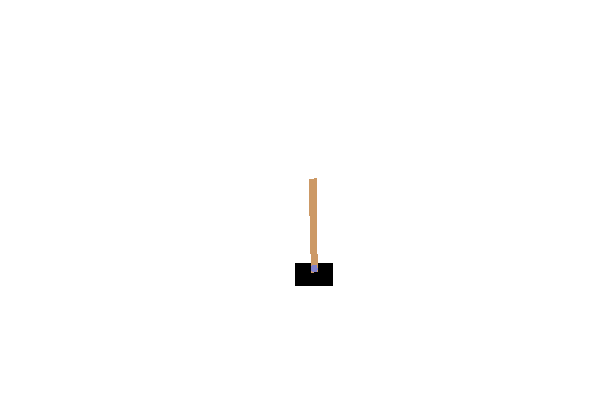
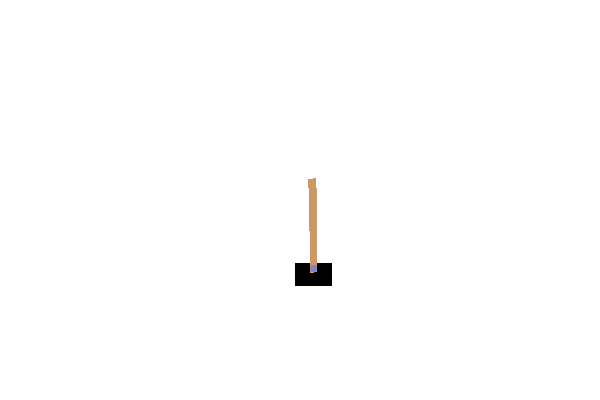
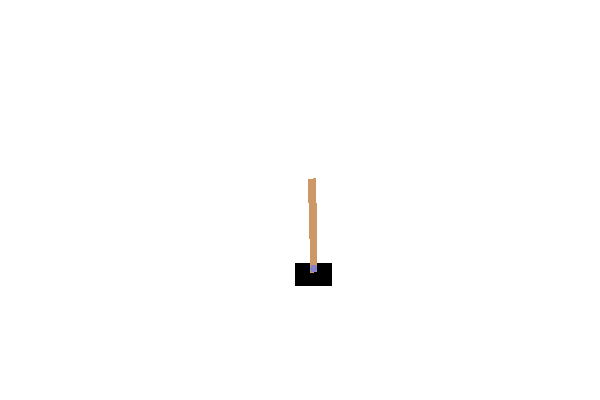
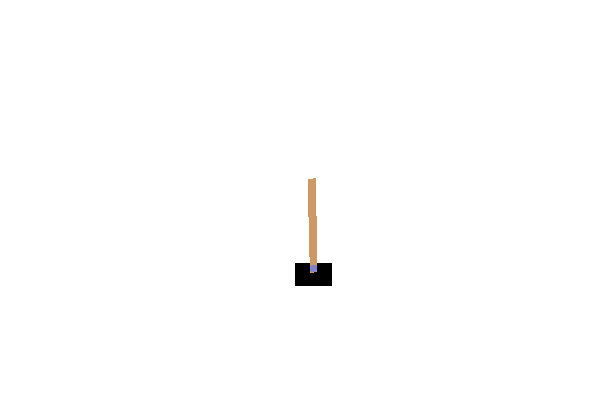
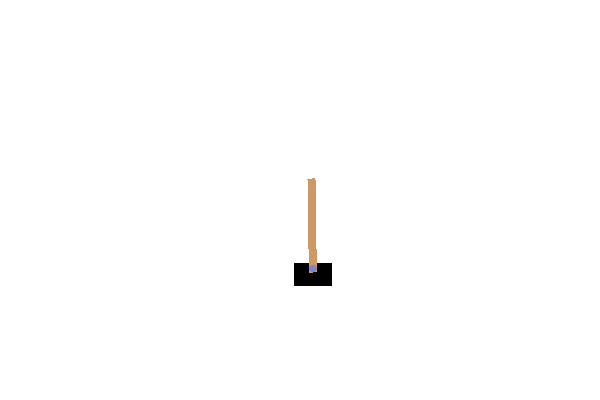
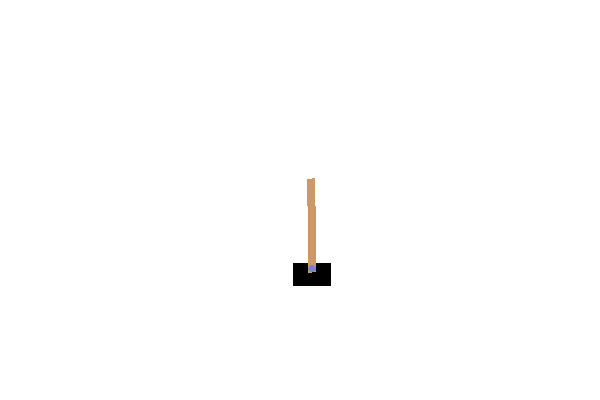
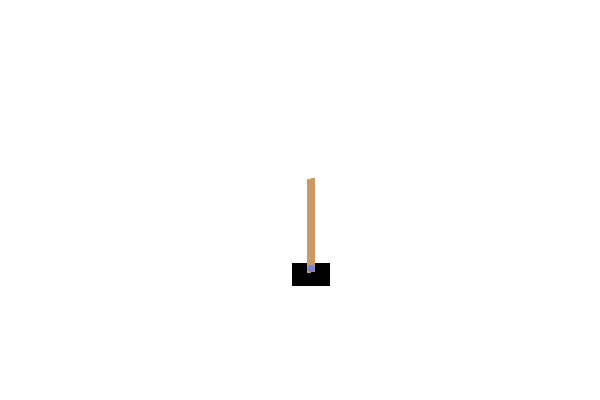
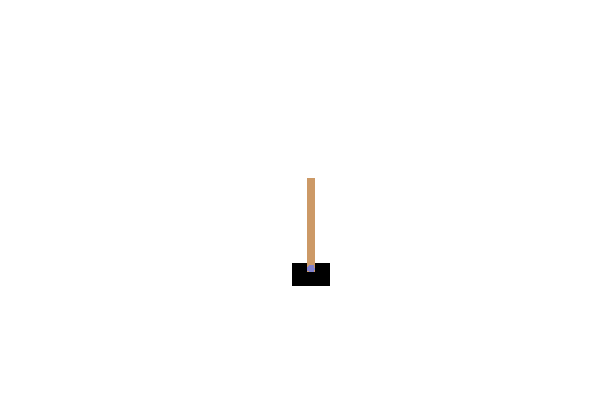
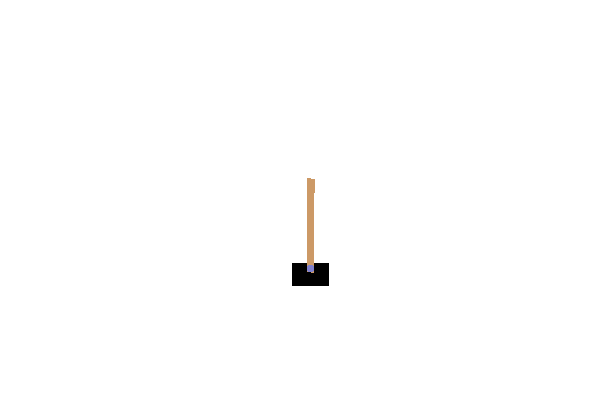
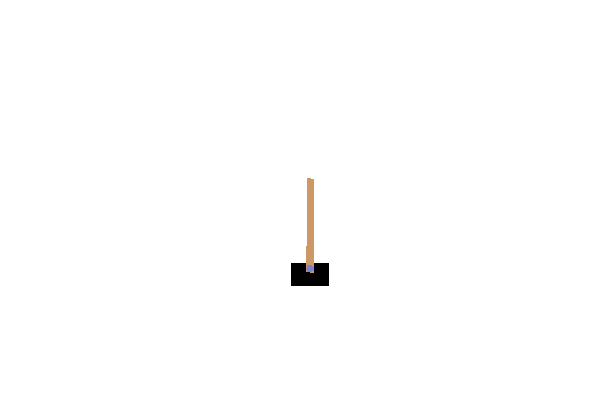
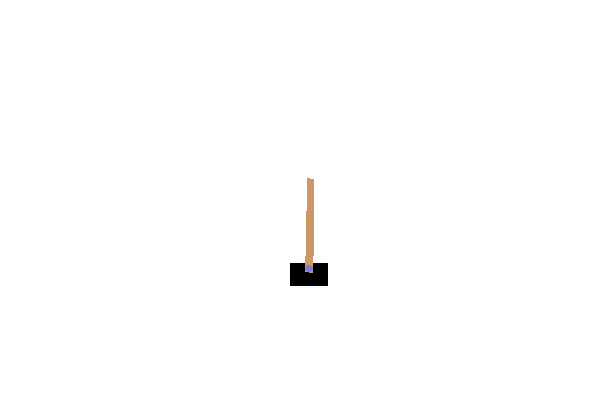
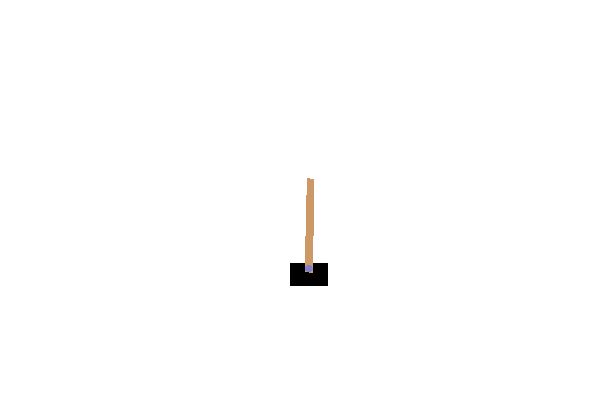
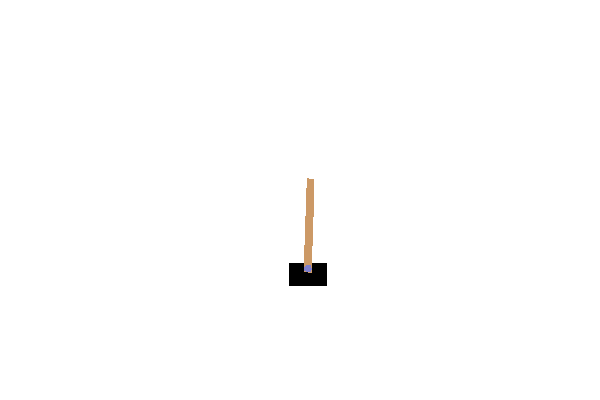
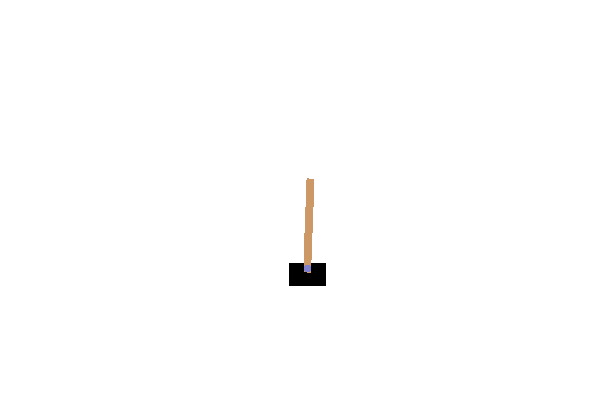
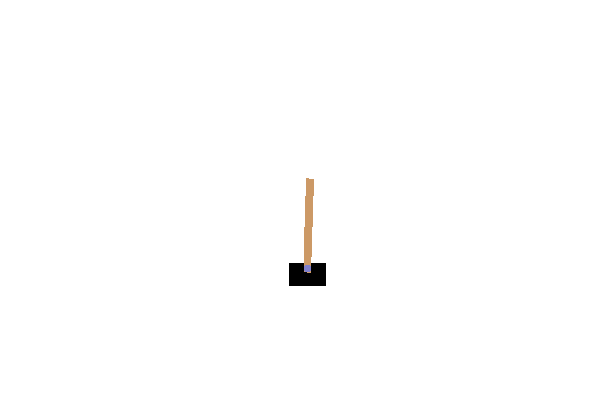
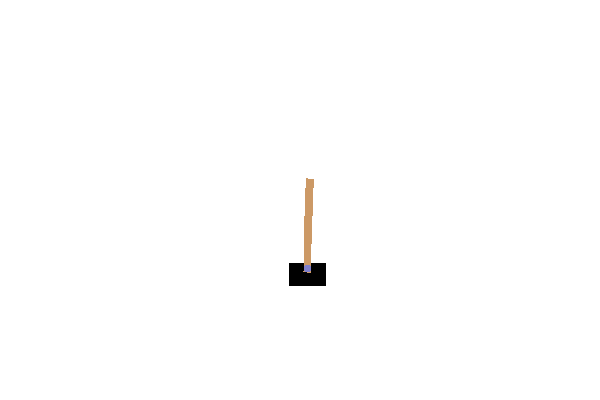
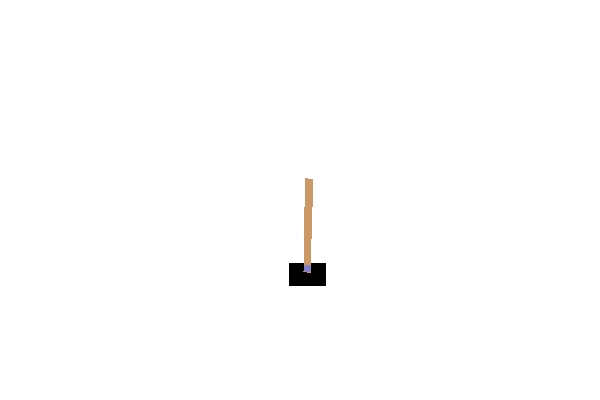
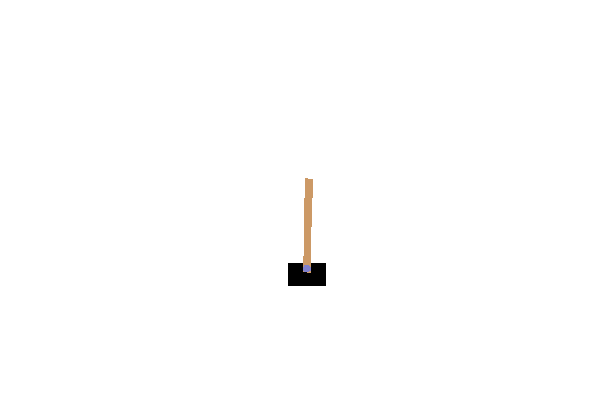
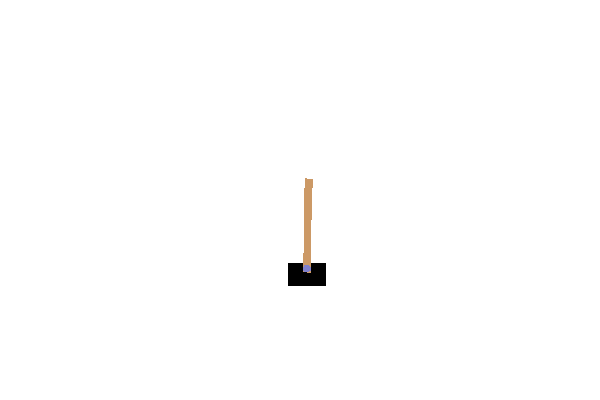
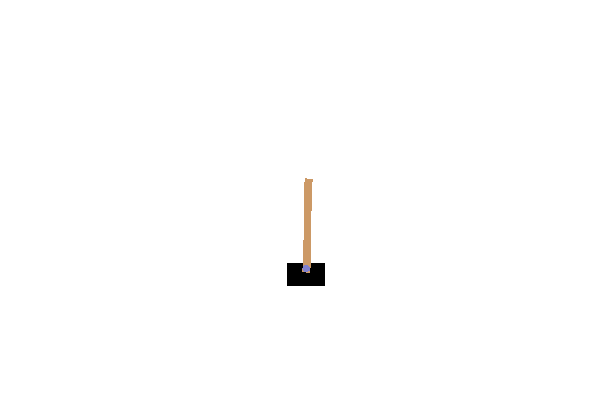
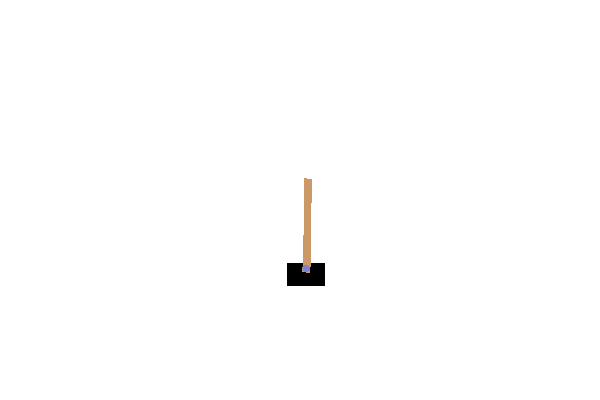
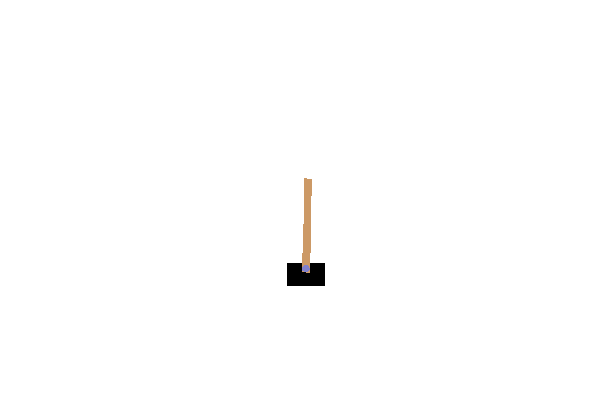
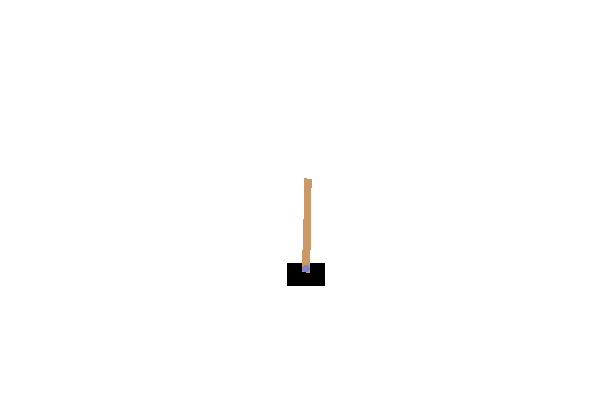
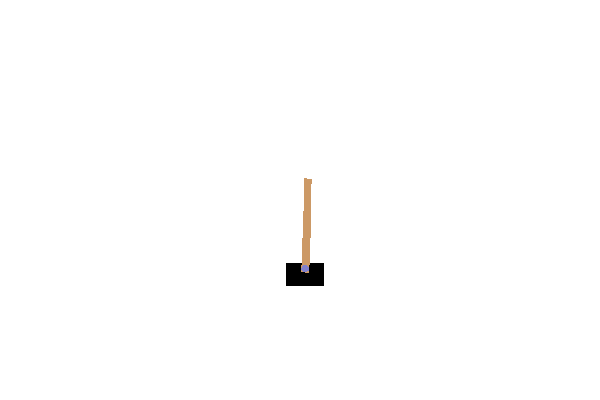
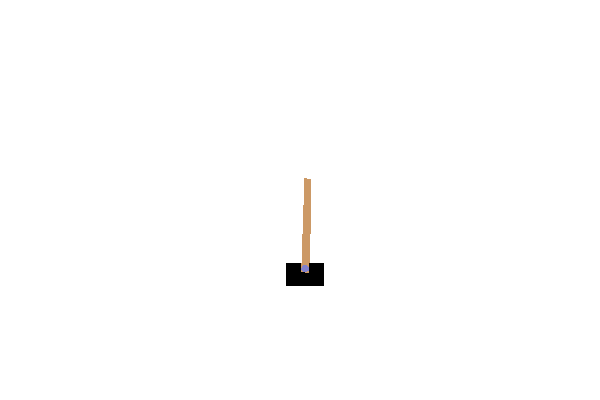
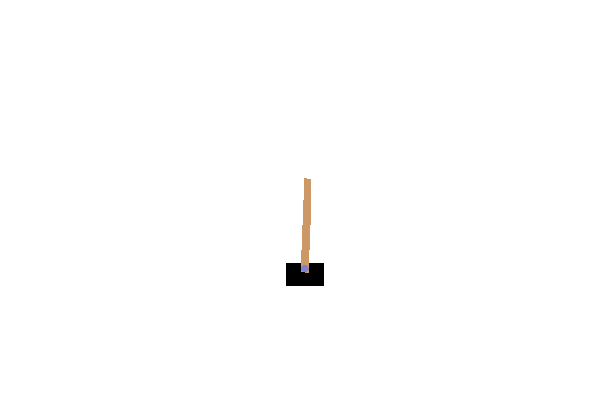
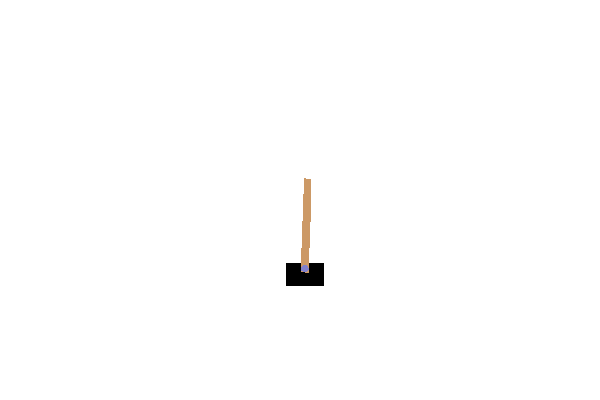
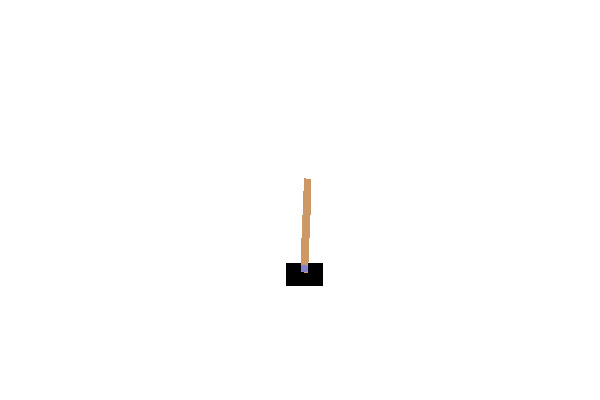
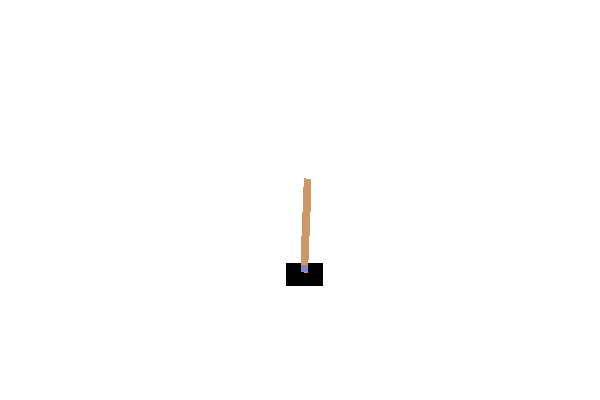
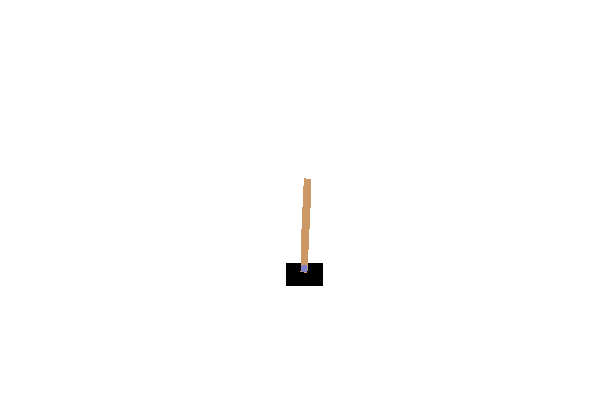
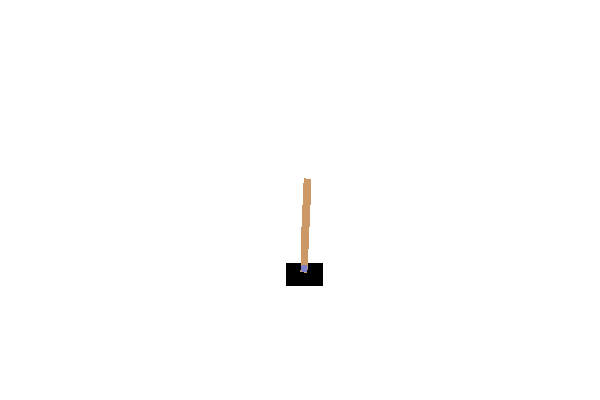
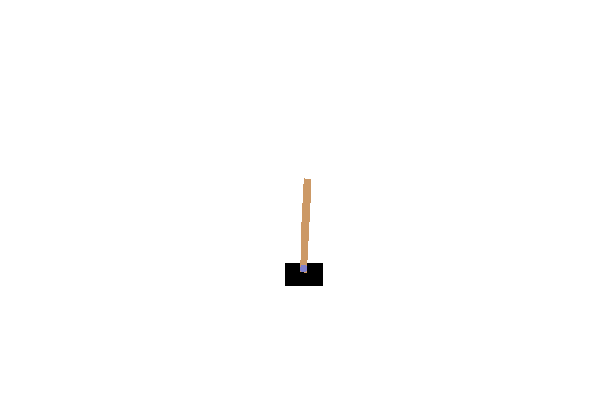
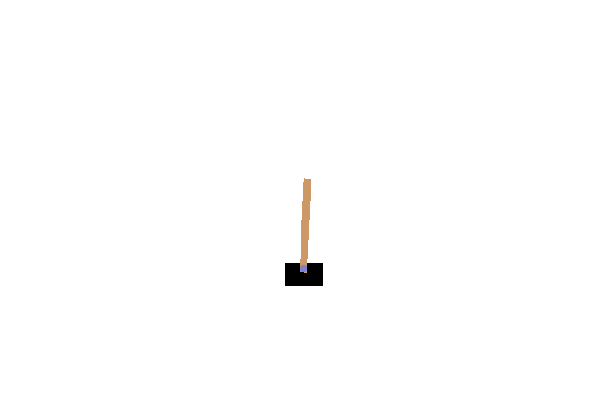
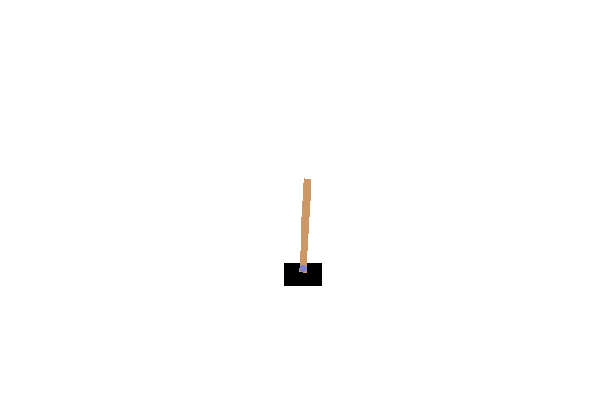
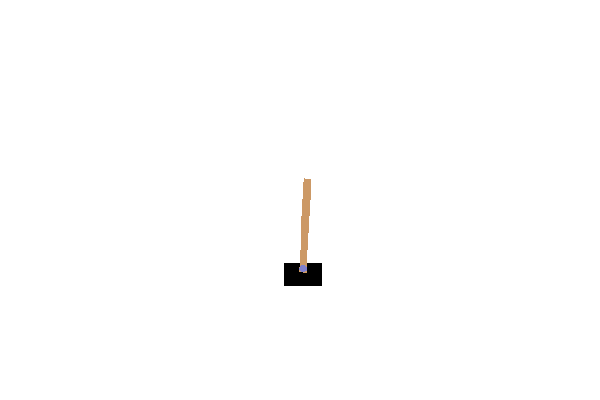
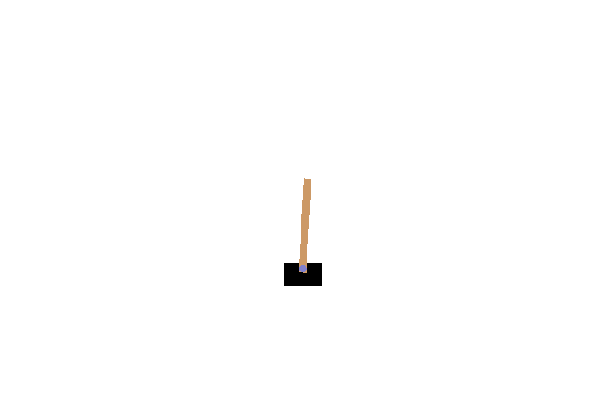
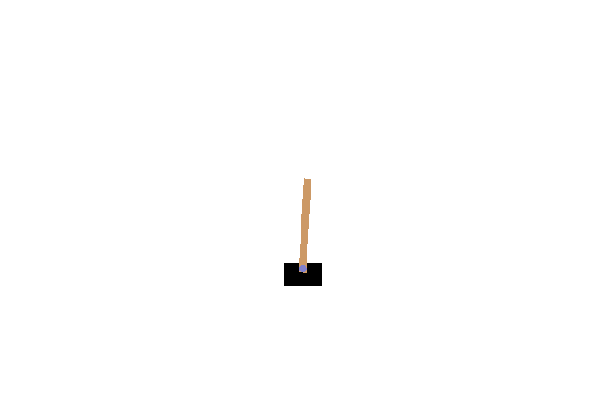
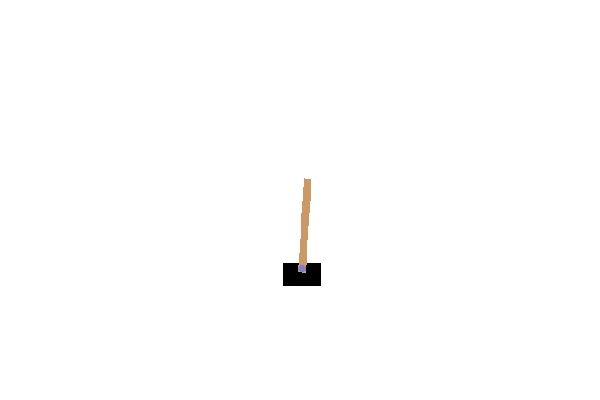
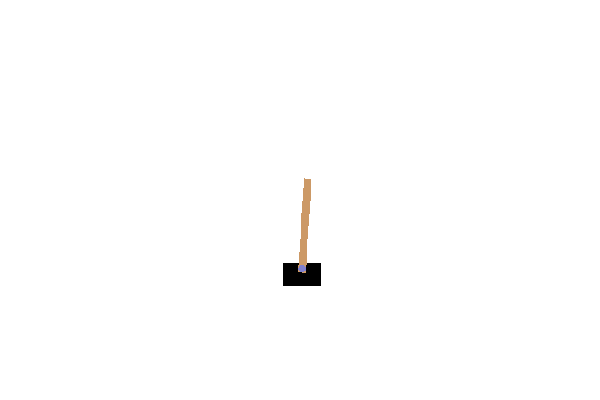
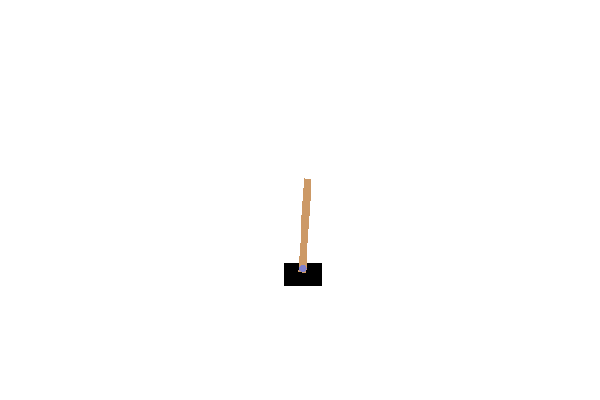
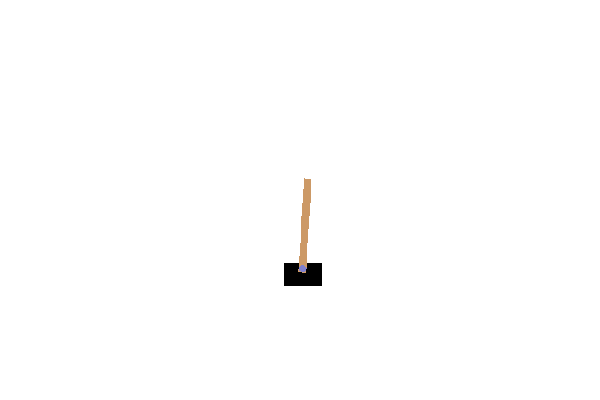
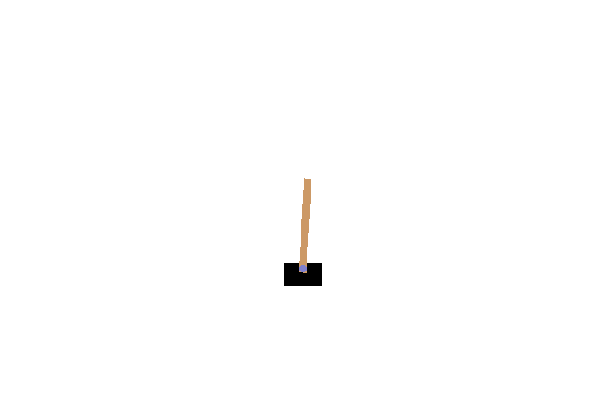
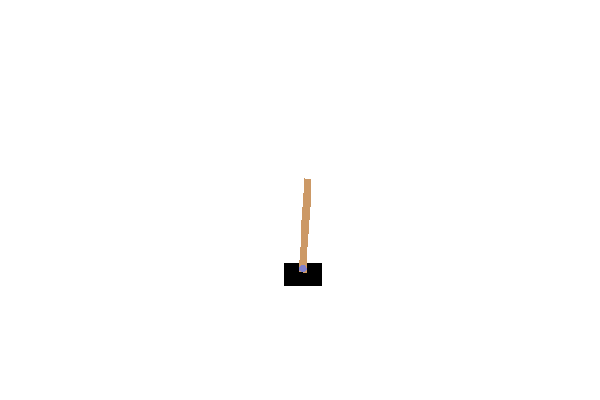
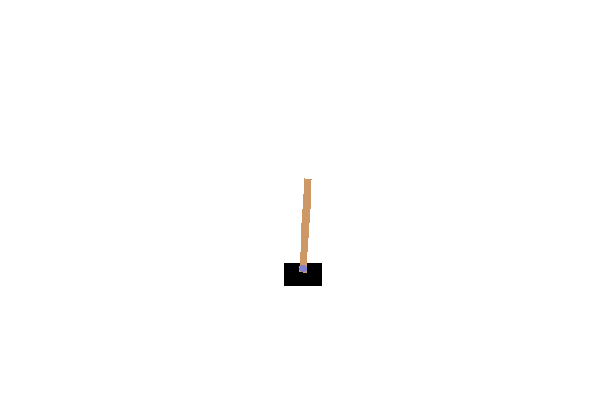
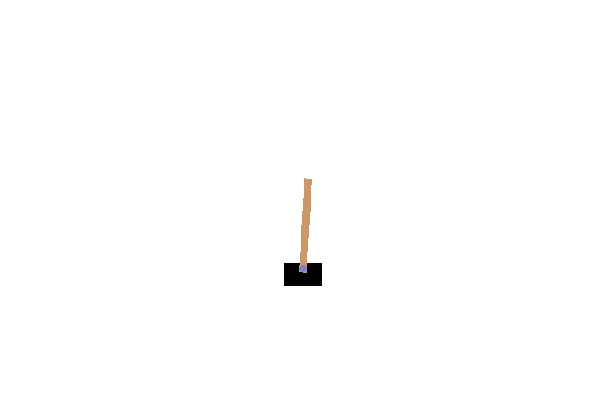
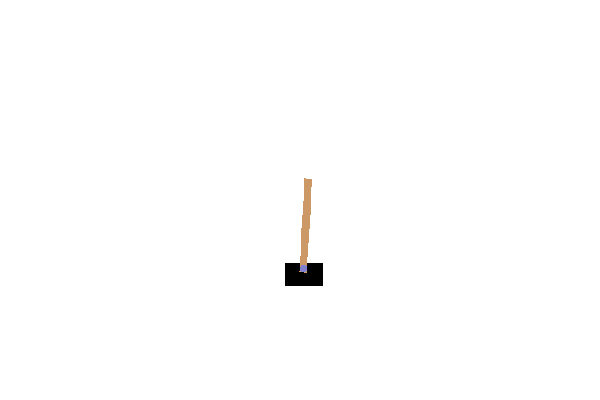
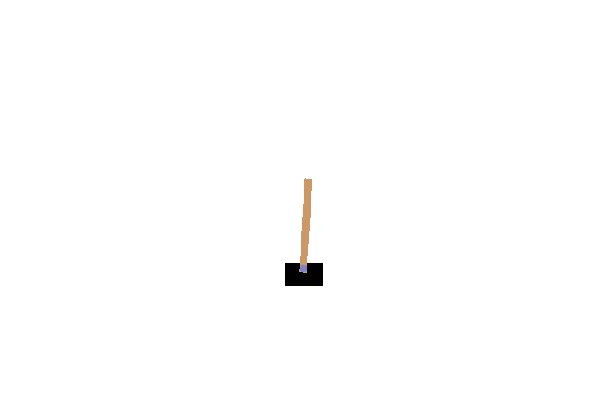
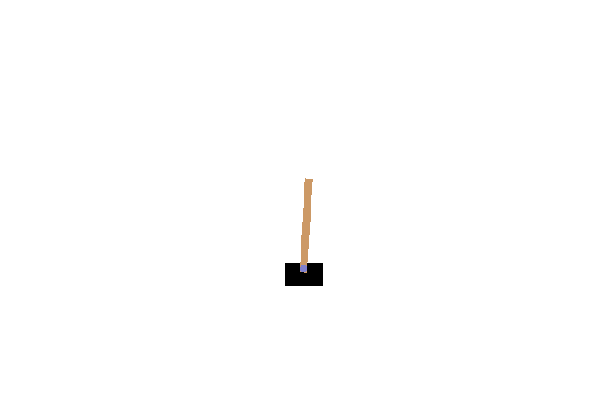
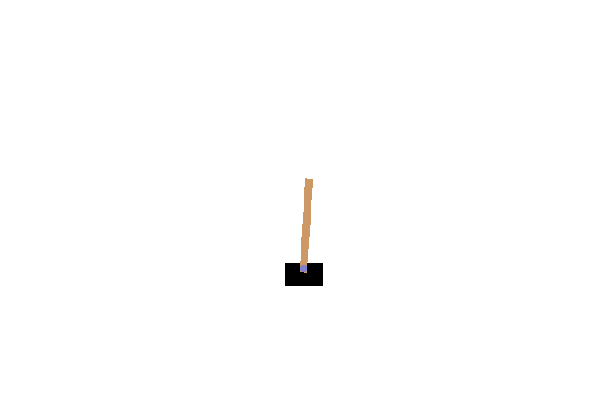
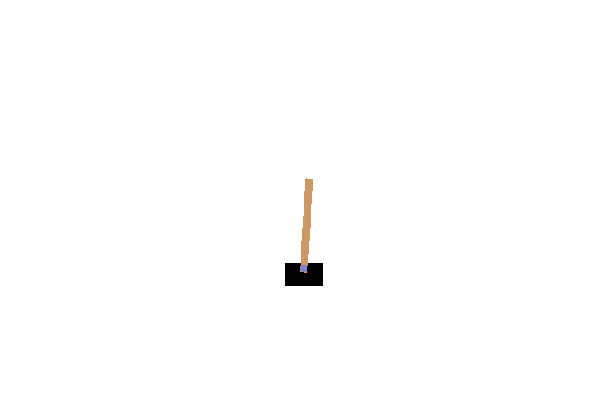
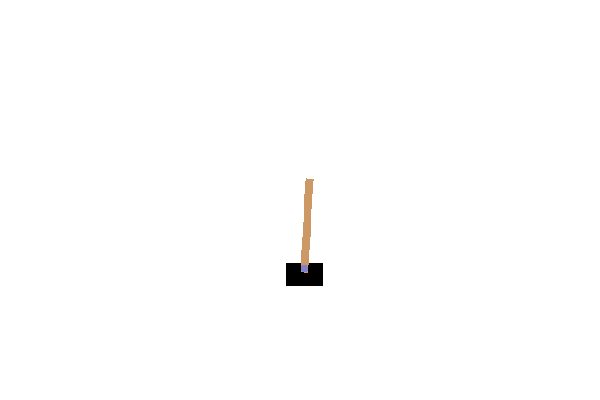
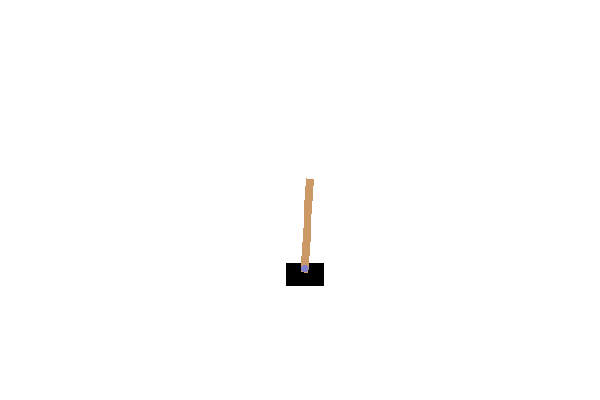
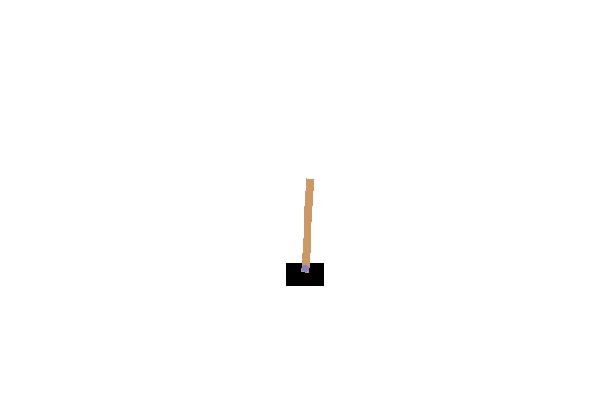
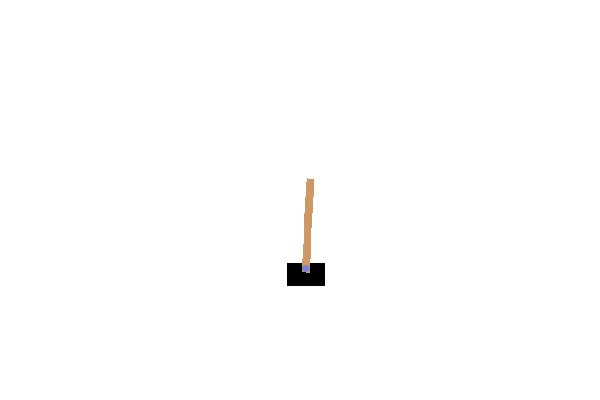
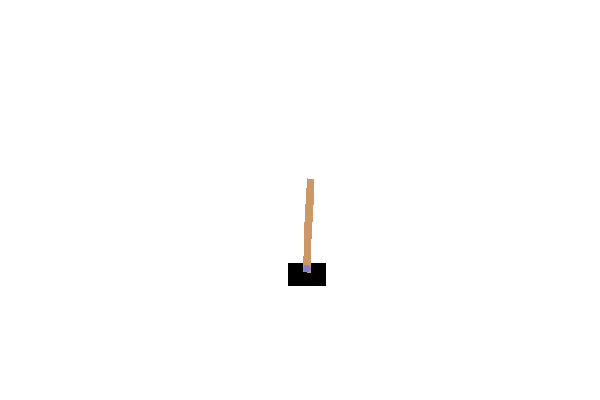
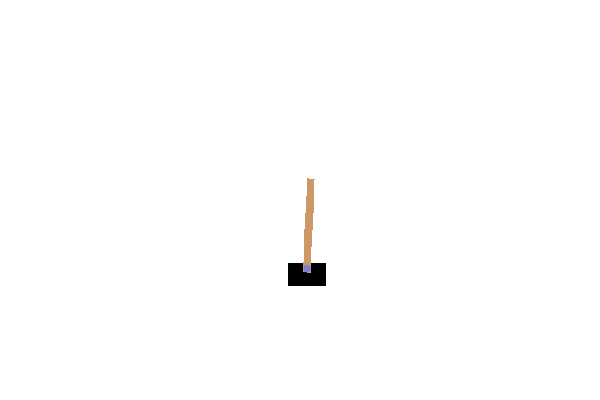
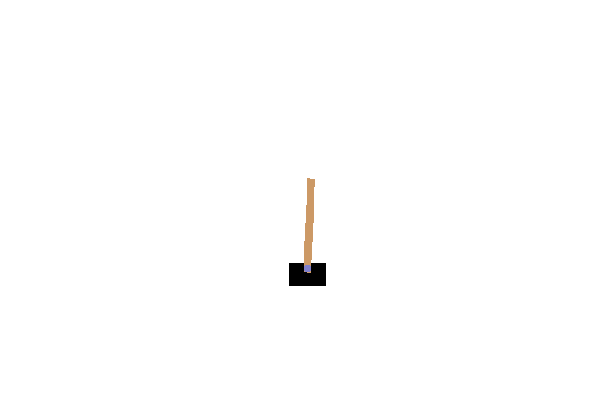
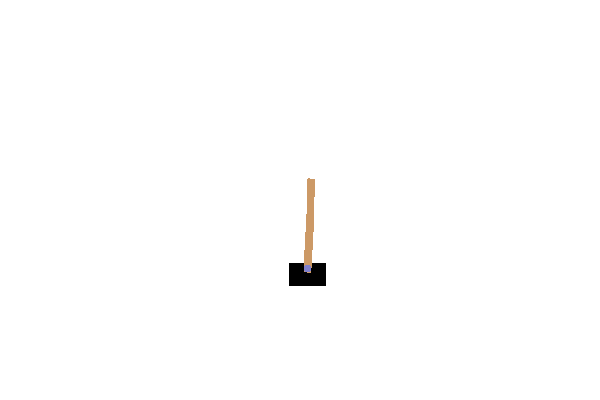
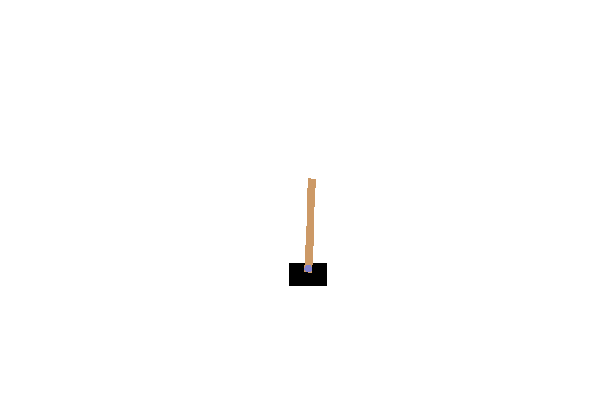
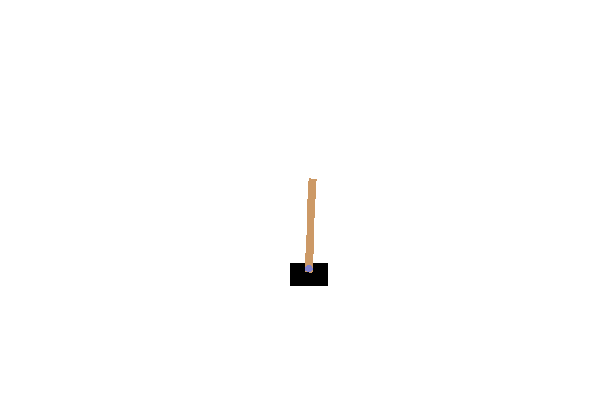
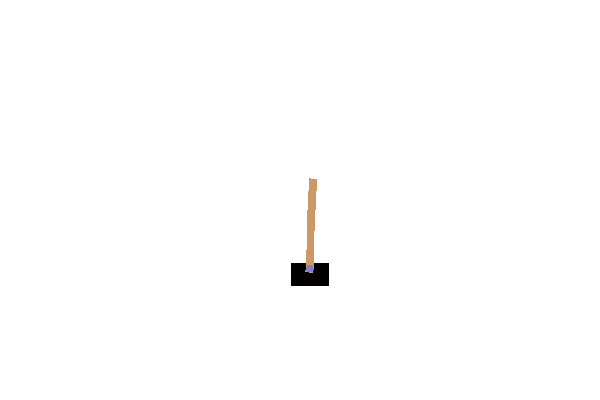
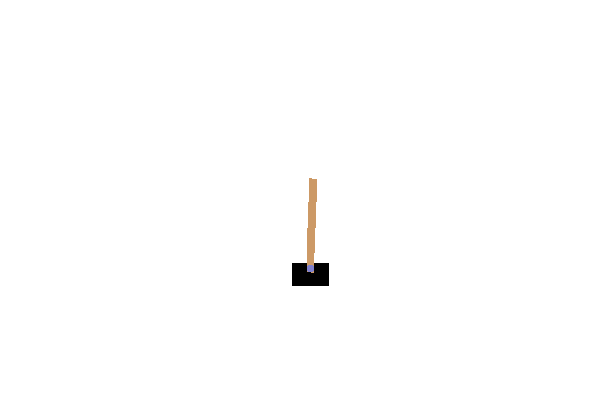
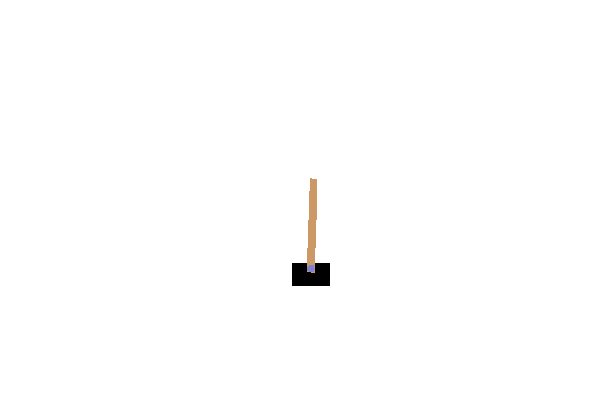
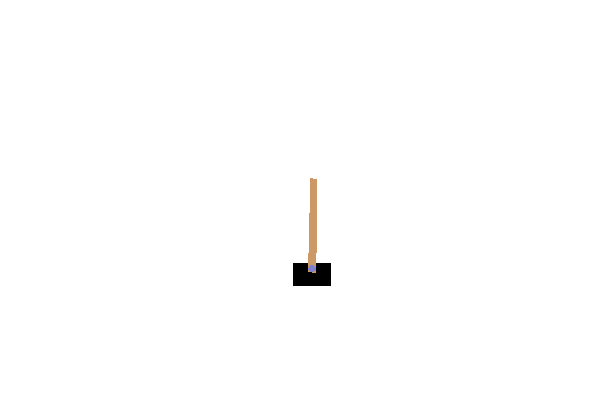
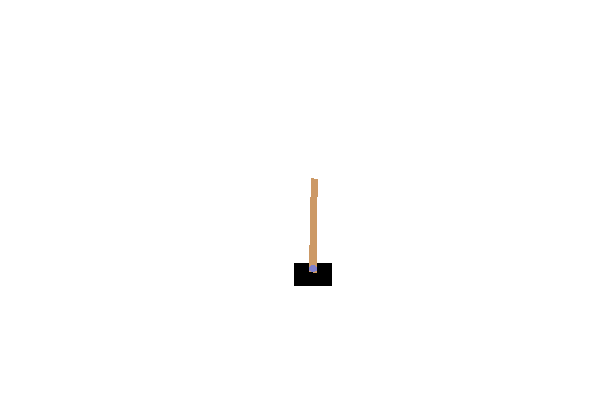
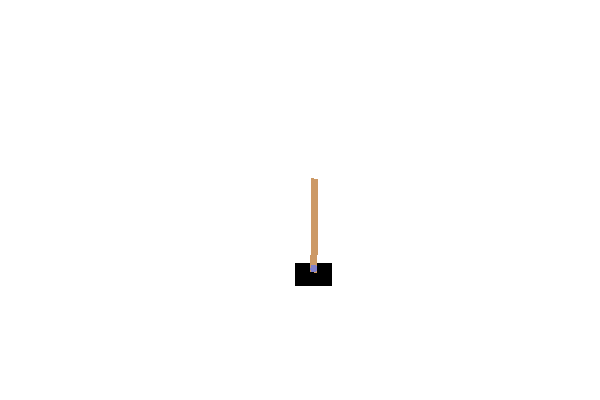
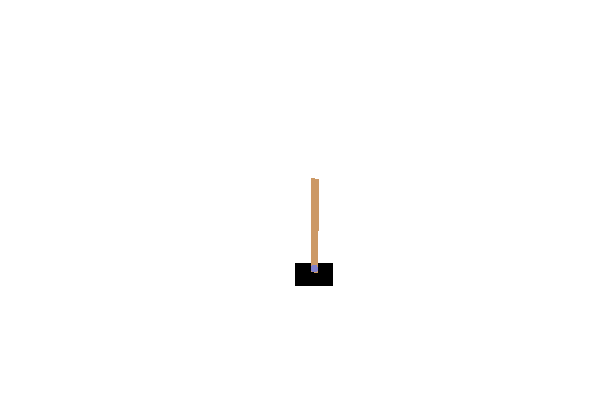
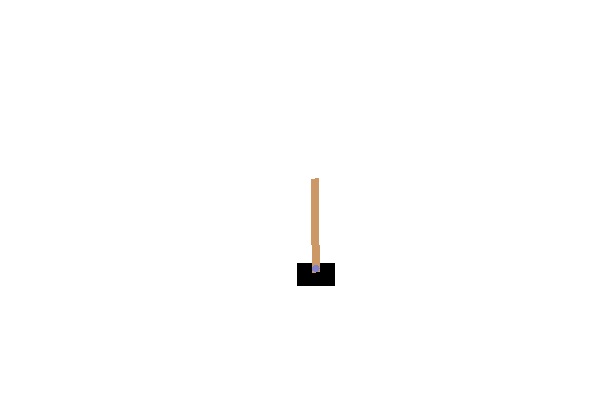
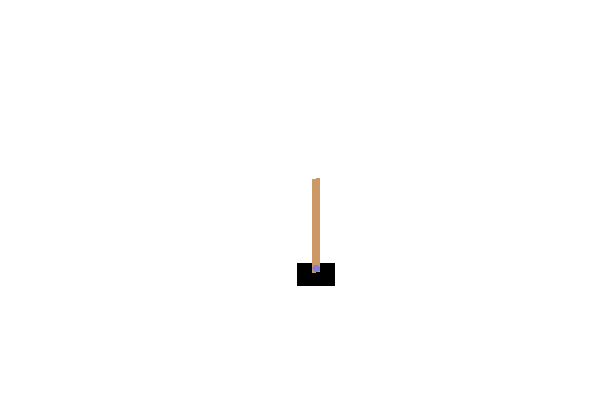
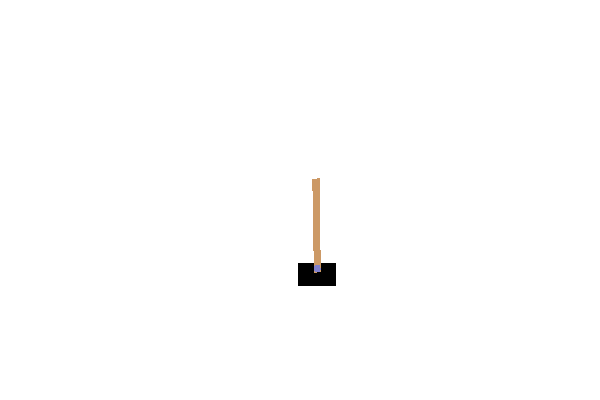
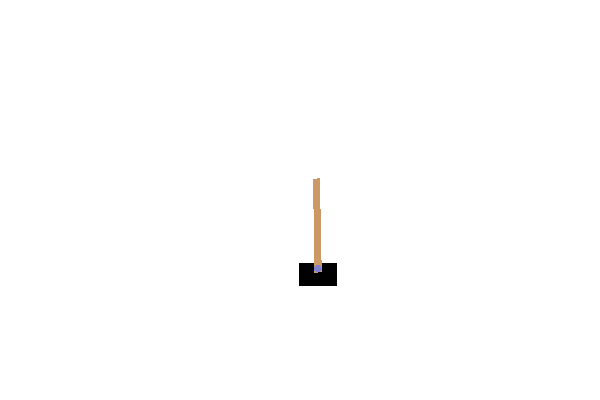
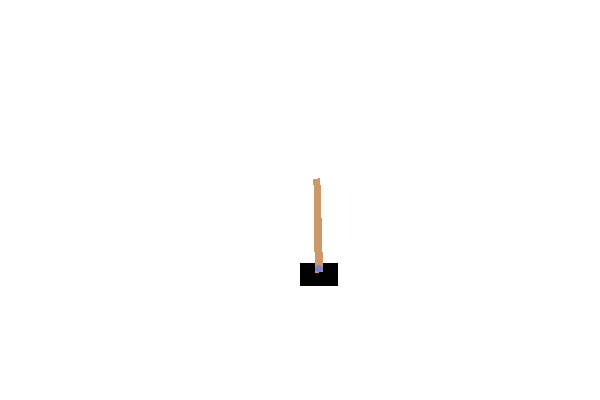
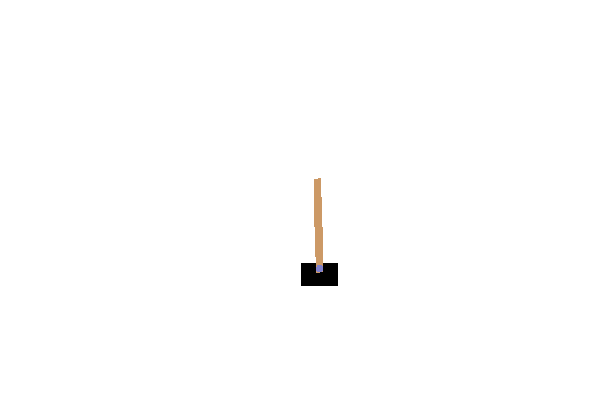

In [10]:
cartpole_env = Environment()
cartpole_env.run()